# Wasserstein Pareto Frontier Experiment on LSAC Data Set (with Post-Processing Interpolation)

## Import Data
The experiment used the CRIME data set as in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc. for comparison purpose: https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_Pandas_Case_Study

In [1]:
import os
import ot
import math
import tempfile
import six.moves.urllib as urllib
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from scipy.linalg import sqrtm
from scipy import stats
from time import perf_counter

# Download the LSAT dataset and setup the required filepaths.
_DATA_ROOT = tempfile.mkdtemp(prefix='lsat-data')
_DATA_PATH = 'https://storage.googleapis.com/lawschool_dataset/bar_pass_prediction.csv'
_DATA_FILEPATH = os.path.join(_DATA_ROOT, 'bar_pass_prediction.csv')
data = urllib.request.urlopen(_DATA_PATH)
df = pd.read_csv(data)

# independnet variable features
X_features = ["gender","lsat","pass_bar","cluster","zfygpa","zgpa","fam_inc","age"]
# dependnet variable features
Y_features = ["gpa"]
# sensitive variable features
Z_features = ["race1"]

Data = df[["gender", "lsat","pass_bar","race1","cluster","zfygpa","zgpa","fam_inc","age","gpa"]]
# remove "nan"
Data_total = Data[((Data["gender"] == 'male') | (Data["gender"] == 'female')) & (Data["race1"] != 'nan')].dropna()
# create binary variables
Data_total = Data_total.replace(['female','male','white','asian', 'black', 'hisp', 'other'] , [0,1,0,1,1,1,1])

# independent variable w/o the sensitive variable: X_d
X_d = np.array(Data_total[X_features])
# direct sum of X_d and Z: X
X = np.array(Data_total[X_features+Z_features])
# dependent variable: Y
Y = np.array(Data_total[Y_features])[:,0]
# sensitive variable: Z
Z = np.array(Data_total[Z_features])[:,0]

# five-fold cross validation data sets
trainX_list = []
trainX_d_list = []
trainY_list = []
trainZ_list = []
testX_list = []
testX_d_list = []
testY_list = []
testZ_list = []

for i in range(0,5):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, random_state=i)
    trainX_list.append(trainX)
    testX_list.append(testX)
    trainY_list.append(trainY)
    testY_list.append(testY)
    trainZ_list.append((trainX[:,8] == 1)*1)
    testZ_list.append((testX[:,8] == 1)*1)

for i in range(0,5):
    trainX_d, testX_d, trainY, testY = train_test_split(X_d, Y, test_size=0.1, random_state=i)
    trainX_d_list.append(trainX_d)
    testX_d_list.append(testX_d)
    

## Compute the Fair Data Representation (Wasserstein Pseudo-barycenter Pair)

In [2]:
# Compute the Wasserstein pseudo-barycenter for X
s = perf_counter() # time recording

# mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
X_d_mean = np.mean(X_d,axis = 0)
X_d_cov = np.cov(X_d.T)
Y_mean = np.mean(Y)
Y_cov = np.cov(Y.T)

# marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
X_A = X_d[Z == 0,:]
Y_A = Y[Z == 0]
X_C = X_d[Z == 1,:]
Y_C = Y[Z == 1]

X_A_mean = np.average(X_A, axis = 0)
Y_A_mean = np.average(Y_A)
X_C_mean = np.average(X_C, axis = 0)
Y_C_mean = np.average(Y_C)

X_A_cov = np.cov(X_A.T)
Y_A_cov = np.cov(Y_A.T)
X_C_cov = np.cov(X_C.T)
Y_C_cov = np.cov(Y_C.T)

# cross-covariance (matrix) between Y and X: yX_A(C)_cov
yX_A_cov = np.cov(Y_A.T, X_A.T)[range(1, 1 + len(X_d[0,:])),0]
yX_C_cov = np.cov(Y_C.T, X_C.T)[range(1, 1 + len(X_d[0,:])),0]

# algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
sample_size = len(X_d[:,0]) 
X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
eps = 10 # initialization for the stop variable

while eps > 0.0000000000001:
    print(eps)
    X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
    eps = np.linalg.norm(X_bar - X_new)
    X_bar = X_new

# algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))

# wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
X_TrainFairList = []
X_TestFairList = []
X_fair = np.random.rand(X_d.shape[0],X_d.shape[1])

X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y, test_size=0.1, random_state=i)
    X_TrainFairList.append(trainX)
    X_TestFairList.append(testX)
    
# Compute the Wasserstein Pseudo-barycenter for E(Y|X)

# marginal/conditional X_fair: X_fair_A(C)
X_fair_A = X_fair[Z == 0,:]
X_fair_C = X_fair[Z == 1,:]

# mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
X_fair_A_mean = np.average(X_fair_A, axis = 0)
X_fair_C_mean = np.average(X_fair_C, axis = 0)
X_fair_A_cov = np.cov(X_fair_A.T)
X_fair_C_cov = np.cov(X_fair_C.T)

# cross-covariance between Y and X_fair: yX_fair_A(C)_cov
yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,1 + len(X_d[0,:])),0]
yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,1 + len(X_d[0,:])),0]

# covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
# which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T

# algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
Y_bar = np.random.rand() 
eps = 10

while eps > 0.0000000000001:
    Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
    eps = Y_bar - Y_new
    Y_bar = Y_new

# algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))

# wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
Y_TrainFairList = []
Y_TestFairList = []
Y_fair = np.random.rand(len(Y))

Y_fair[Z == 0] = (Y[Z == 0] - Y_A_mean) * T_Y_A + Y_mean
Y_fair[Z == 1] = (Y[Z == 1] - Y_C_mean) * T_Y_C + Y_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y_fair, test_size=0.1, random_state=i)
    Y_TrainFairList.append(trainy)
    Y_TestFairList.append(testy)
    
time_fair = perf_counter() - s

10
52.89423519796512
240.9151604250031
247.74236518444204
101.86951110983532
31.69611852612939
44.35033282411813
64.68514854175879
118.94216904057672
92.2263711074632
118.81763731655143
152.36803443598689
150.87054746875114
119.38022494753383
92.31394002861393
186.0220331559835
205.81930165098365
159.1417916405811
94.72561001167549
51.00309476900601
47.40714396396443
51.56081301370192
36.584203649861635
21.80294671166064
12.808548327999658
9.261658718346338
8.741746248412522
8.954950325863148
9.088679962753746
9.034215567751513
8.836182198032724
8.548583447449532
8.210457328721091
7.846881232853711
7.473381397609836
7.099476738680562
6.730997459192499
6.371509436669899
6.023173862050678
5.687267035721012
5.364498477751717
5.055209009133085
4.759496535670298
4.47729743487295
4.20844003625236
3.9526800903311394
3.7097243160706004
3.47924590034308
3.260894538329393
3.0543028314056064
2.8590903976707964
2.674866717537066
2.501233476174617
2.3377869086563114
2.1841203902252553
2.03982726405

3.914378285902713e-08
3.771794404708972e-08
3.6344046884938e-08
3.502020651998133e-08
3.374458241216537e-08
3.251543900276457e-08
3.133106610568256e-08
3.018983820675558e-08
2.9090188038510748e-08
2.8030596318214497e-08
2.700959812271398e-08
2.6025799185898446e-08
2.5077835749063937e-08
2.416440341940466e-08
2.3284248144460663e-08
2.2436150997270157e-08
2.161895087564782e-08
2.0831516022715957e-08
2.007276816071543e-08
1.934165796062259e-08
1.8637181037447983e-08
1.7958364317835797e-08
1.730427324352478e-08
1.667401067269331e-08
1.6066706754705158e-08
1.5481521431407686e-08
1.4917652085440842e-08
1.4374322951246746e-08
1.3850787517029198e-08
1.3346319343232722e-08
1.2860225799801854e-08
1.2391835842987605e-08
1.1940513947068403e-08
1.1505625462291093e-08
1.1086578052830424e-08
1.0682795808511046e-08
1.0293722631897522e-08
9.918819048542222e-09
9.557570224656484e-09
9.209479010810723e-09
8.874068519533603e-09
8.550875144940043e-09
8.239452081210004e-09
7.939369639100604e-09
7.6502226988

<ipython-input-2-21b51c7cc363>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-2-21b51c7cc363>:51: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean


### Recoding the time to compute the pseudo-barycenter

In [3]:
time_fair

1.4133094470000014

## Estimate the path of (X,Y) that results in the geodesic path from the E(Y|X_z) to the barycenter of the marginal conditional expectations
1. Compute both geodesic path path from X to X^dash and from Y to Y^dash
2. Use diagonal argument to estimate the geodesic path from the original E(Y|X) to E(Y^dash|X^dash) on both train and test data sets: X_train/test_path_list, Y_train\test_path_list

In [4]:
X_train_path_list = []
X_test_path_list = []
Y_train_path_list = []
Y_test_path_list = []

s = perf_counter()
T = np.linspace(0,1,50) # discretize time variable T
# Algorithm 1, step 3: estimate of the independent variable (X) geodesic path using McCann interpolation
for i in range(0,len(trainX_list)):
    X_d = trainX_d_list[i]
    Y = trainY_list[i]
    Z = trainZ_list[i]
    Z_test = testZ_list[i]
    # mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
    X_d_mean = np.mean(X_d,axis = 0)
    X_d_cov = np.cov(X_d.T)
    Y_mean = np.mean(Y)
    Y_cov = np.cov(Y.T)
    # marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
    X_A = X_d[Z == 0,:]
    Y_A = Y[Z == 0]
    X_C = X_d[Z == 1,:]
    Y_C = Y[Z == 1]
    X_A_mean = np.average(X_A, axis = 0)
    Y_A_mean = np.average(Y_A)
    X_C_mean = np.average(X_C, axis = 0)
    Y_C_mean = np.average(Y_C)
    X_A_cov = np.cov(X_A.T)
    Y_A_cov = np.cov(Y_A.T)
    X_C_cov = np.cov(X_C.T)
    Y_C_cov = np.cov(Y_C.T)
    # cross-covariance (matrix) between Y and X: yX_A(C)_cov
    yX_A_cov = np.cov(Y_A.T, X_A.T)[range(1, 1 + len(X_d[0,:])),0]
    yX_C_cov = np.cov(Y_C.T, X_C.T)[range(1, 1 + len(X_d[0,:])),0]
    # algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.00000000000
    sample_size = len(X_d[:,0]) 
    X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
    eps = 10 # initialization for the stop variable
    while eps > 0.0000000000001:
        print(eps)
        X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
        eps = np.linalg.norm(X_bar - X_new)
        X_bar = X_new
    # algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
    T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
    T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))
    # wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
    X_fair = np.random.rand(X_d.shape[0],X_d.shape[1])
    X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
    X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean
    # generate the geodesic path
    X_train_path = []
    X_test_path = []
    for t in range(0,len(T)):
        temp = np.zeros(X_d.shape)
        temp_test = np.zeros(testX_d_list[i].shape)
        temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        temp_test[Z_test == 0,:] = (1-T[t])*testX_d_list[i][Z_test == 0,:] + T[t]*((testX_d_list[i][Z_test == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp_test[Z_test == 1,:] = (1-T[t])*testX_d_list[i][Z_test == 1,:] + T[t]*((testX_d_list[i][Z_test == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        # Algorithm 1, step 4: merge the corresponding (wrt t) linear interpolation of sensitive variable back to the MacCann interpolation of dependnet variable
        temp_more = np.concatenate((temp, Z[...,np.newaxis]),axis = 1)
        temp_more_test = np.concatenate((temp_test, Z_test[...,np.newaxis]),axis = 1)
        X_train_path.append(temp_more)
        X_test_path.append(temp_more_test)
    
    # Compute the Wasserstein Pseudo-barycenter for E(Y|X)
    # marginal/conditional X_fair: X_fair_A(C)
    X_fair_A = X_fair[Z == 0,:]
    X_fair_C = X_fair[Z == 1,:]
    # mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
    X_fair_A_mean = np.average(X_fair_A, axis = 0)
    X_fair_C_mean = np.average(X_fair_C, axis = 0)
    X_fair_A_cov = np.cov(X_fair_A.T)
    X_fair_C_cov = np.cov(X_fair_C.T)
    # cross-covariance between Y and X_fair: yX_fair_A(C)_cov
    yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,1 + len(X_d[0,:])),0]
    yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,1 + len(X_d[0,:])),0]
    # covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
    # which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
    yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
    yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T
    # algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    Y_bar = np.random.rand() 
    eps = 10
    while eps > 0.0000000000001:
        Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
        eps = Y_bar - Y_new
        Y_bar = Y_new 
    # algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
    T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
    T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))
    # wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
    Y_fair = np.random.rand(len(Y))
    Y_fair[Z == 0] = (Y[Z == 0] - Y_A_mean) * T_Y_A + Y_mean
    Y_fair[Z == 1] = (Y[Z == 1] - Y_C_mean) * T_Y_C + Y_mean
    # generate the geodesic path
    Y_train_path = []
    Y_test_path = []
    for t in range(0,len(T)):
        temp = np.random.rand(len(Y))
        temp_test = np.random.rand(len(testY_list[i]))
        temp[Z == 0] = (1 - T[t] + T[t]*T_Y_A)*Y[Z == 0] + T[t]*(Y_mean - T_Y_A*Y_A_mean)
        temp[Z == 1] = (1 - T[t] + T[t]*T_Y_C)*Y[Z == 1] + T[t]*(Y_mean - T_Y_C*Y_C_mean)
        temp_test[Z_test == 0] = (1 - T[t] + T[t]*T_Y_A)*testY_list[i][Z_test == 0] + T[t]*(Y_mean - T_Y_A*Y_A_mean)
        temp_test[Z_test == 1] = (1 - T[t] + T[t]*T_Y_C)*testY_list[i][Z_test == 1] + T[t]*(Y_mean - T_Y_C*Y_C_mean)
        Y_train_path.append(temp)
        Y_test_path.append(temp_test)
        
    X_train_path_list.append(X_train_path)
    X_test_path_list.append(X_test_path)
    Y_train_path_list.append(Y_train_path)
    Y_test_path_list.append(Y_test_path)
    
time_fair = perf_counter() - s

10
10.45657287534139
24.42547863089574
25.55463400283641
16.2054139943326
7.921778106422589
4.1683122222614015
3.7351883604677467
3.9056144860788518
3.8872448662506347
3.7158533300599372
3.477657707705119
3.221716382709518
2.9707881480610796
2.734301696645396
2.515536780551705
2.315046087089069
2.132202678596474
1.965889712346542
1.814811169096884
1.677636377661533
1.553070250820291
1.439888566300048
1.3369553699603423
1.2432303051340916
1.1577698012342192
1.0797243784147836
1.0083335256950778
0.9429191656661711
0.8828784281412307
0.827676242821857
0.7768380995597057
0.7299432011322882
0.6866181406725907
0.6465311682941048
0.6093870639261935
0.5749226014112022
0.5429025689190363
0.5131162993459344
0.48537465915720035
0.4595074430912332
0.43536112410038774
0.4127969111719327
0.39168907216328125
0.3719234834717035
0.3533963730883568
0.3360132280952196
0.3196878418641497
0.3043414798795602
0.28990214643416606
0.2763039372881087
0.2634864658138021
0.2513943522001144
0.2399767670465463
0.22

1.775098404244801e-08
1.7095219511393315e-08
1.64636768108849e-08
1.585546879428549e-08
1.526972882092364e-08
1.47056289539787e-08
1.4162367364513668e-08
1.3639182010813481e-08
1.3135325055948797e-08
1.2650074630630933e-08
1.2182754615773722e-08
1.1732699637858194e-08
1.1299269085978315e-08
1.0881856281878284e-08
1.0479862931352499e-08
1.0092718884573238e-08
9.719879063111435e-09
9.360808308544293e-09
9.015003181167468e-09
8.681978007578456e-09
8.361255578384685e-09
8.05237675709381e-09
7.754911937983248e-09
7.468437026839471e-09
7.19254197549053e-09
6.926840924005722e-09
6.670957610711397e-09
6.424529648511189e-09
6.187196597302418e-09
5.9586336082187686e-09
5.738522403087456e-09
5.526534774470146e-09
5.3223821047845945e-09
5.1257677022091945e-09
4.9364169442749805e-09
4.754063661114323e-09
4.5784474484332075e-09
4.409314097704017e-09
4.2464326684744075e-09
4.089570314911863e-09
3.938497922700065e-09
3.7930113689000736e-09
3.652892099116326e-09
3.517957817837588e-09
3.388001187418353e

<ipython-input-4-7f6b7592ad10>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-4-7f6b7592ad10>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean
<ipython-input-4-7f6b7592ad10>:57: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
<ipython-input-4-7f6b7592ad10>:58: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
<ipython-input-4-7f6b7592ad10>:59: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_test[Z_test == 0,:] = (1-T[t])*testX_d_list[i][Z_test == 0,:] + T[t]*((testX_d_list[i][Z_test == 0,:] - X_A

10
23.16240559697513
47.94221558661565
34.61885665555484
12.268096324242464
9.357358472217896
12.514935149862227
12.640700761993036
11.37397333268115
9.763781254799465
8.22074346618289
6.870841510212337
5.731891622161546
4.785672203848466
4.0050050051068995
3.363092222257605
2.836227852940789
2.4041967061824225
2.04997853678833
1.7593248414474827
1.520372415075217
1.3233146085218506
1.1601139285206972
1.024240742355784
0.9104324039205531
0.8144739365230265
0.7330035565895915
0.6633453457540847
0.603369267094734
0.5513767816787714
0.5060090836649447
0.46617446119210765
0.4309913149503613
0.3997437015855214
0.3718467367061457
0.3468196782535031
0.32426495493672686
0.30385178185022194
0.28530331244142265
0.26838651905721755
0.2529041832122485
0.23868852205130195
0.22559608853816404
0.21350366744977975
0.20230495359282955
0.1919078475892431
0.1822322418230846
0.17320819760748793
0.1647744363374468
0.156877084107293
0.1494686220871101
0.14250700487785642
0.13595491675594656
0.12977914170065

7.657348998408351e-09
7.3769826543361675e-09
7.1068917223193634e-09
6.846705756877779e-09
6.596056591405147e-09
6.3545936382097795e-09
6.121990055096382e-09
5.897901818217341e-09
5.682031540682117e-09
5.474073623599277e-09
5.273738533398214e-09
5.080738114317648e-09
4.894814819757359e-09
4.715702156772547e-09
4.543149489891041e-09
4.376923730499018e-09
4.216785236007451e-09
4.062513249170159e-09
3.913891216900976e-09
3.770712716222368e-09
3.6327797470898048e-09
3.4998992029098903e-09
3.3718852553987115e-09
3.2485575383771833e-09
3.1297455146938926e-09
3.0152846425443695e-09
2.905019010676926e-09
2.798785478922764e-09
2.696444075017757e-09
2.5978445707083256e-09
2.50285866784713e-09
2.411350662713593e-09
2.3231922484995324e-09
2.2382596370093878e-09
2.1564341423196316e-09
2.077605630933895e-09
2.0016588831221095e-09
1.9284950209875853e-09
1.8580021213553757e-09
1.7900954505957781e-09
1.7246696667055464e-09
1.661640082008672e-09
1.6009176377101646e-09
1.542417246802665e-09
1.486053605512

0.018240006072263924
0.01754111362586717
0.01687005737838034
0.016225641011395845
0.015606726768313947
0.015012232039634251
0.014441126184645577
0.013892427571152466
0.013365200816104757
0.01285855421168948
0.012371637322336322
0.011903638740022897
0.011453783985328314
0.011021333543831667
0.01060558102735618
0.010205851450990717
0.009821499617364286
0.009451908600321482
0.009096488320935587
0.008754674209104366
0.008425925944772652
0.008109726273159153
0.007805579888762707
0.0075130123836334006
0.007231569255140715
0.006960814969648172
0.006700332078026068
0.006449720379704236
0.006208596132134639
0.0059765913025712535
0.005753352859611199
0.00553854210185828
0.00533183402142426
0.0051329167001444315
0.00494149073644053
0.0047572687009445076
0.004579974619326514
0.004409343480449362
0.004245120768615033
0.004087062018378769
0.003934932390657065
0.003788506268887614
0.0036475668742358067
0.0035119058986709507
0.0033813231549621697
0.00325562624274909
0.0031346302297908745
0.00301815734

9.029392735037116e-09
8.699574177979028e-09
8.381804071579632e-09
8.075651986890773e-09
7.780686005008788e-09
7.496508813333683e-09
7.222695412736141e-09
6.958894874876868e-09
6.704717435145186e-09
6.4598434296224165e-09
6.22391810081148e-09
5.996607073471904e-09
5.777596443751619e-09
5.566591199443553e-09
5.363294649574509e-09
5.167414660425725e-09
4.978713490671453e-09
4.7968932802561085e-09
4.621706969471664e-09
4.452925190236012e-09
4.290314066136119e-09
4.133643525406254e-09
3.982699605422332e-09
3.837259899829213e-09
3.697133771740936e-09
3.562131354218953e-09
3.4320530637454543e-09
3.30673214433657e-09
3.1859850756115675e-09
3.0696488794981115e-09
2.957561491414626e-09
2.849573971488434e-09
2.7455241061912317e-09
2.645274664797752e-09
2.548689868348097e-09
2.4556324630345228e-09
2.36597232181604e-09
2.279587311237975e-09
2.1963559062498057e-09
2.1161617848044986e-09
2.0389082523209888e-09
1.9644625751107418e-09
1.8927468222605403e-09
1.8236361549093706e-09
1.7570566429788195e-09

0.0587975504536039
0.05666571412936454
0.05461124805737465
0.052631338415726786
0.05072327421704664
0.04888444350248626
0.04711232968144316
0.045404508011289674
0.043758642210861586
0.04217248120251528
0.04064385597721011
0.03917067657759025
0.03775092919466246
0.036382673373091146
0.03506403932105475
0.03379322532047279
0.03256849523380273
0.03138817610329233
0.030250655839728333
0.029154380996519867
0.028097854626245724
0.02707963421664193
0.026098329702590958
0.025152601551532584
0.024241158919461908
0.023362757874746672
0.02251619968732452
0.021700329180826965
0.02091403314514124
0.02015623880727616
0.019425912358391913
0.01872205753465359
0.01804371425025787
0.01738995728041938
0.016759894992567054
0.016152668124007216
0.01556744860416543
0.015003438420027907
0.014459868522909257
0.013935997775226175
0.013431111935655417
0.012944522681428042
0.012475566666200852
0.012023604612264226
0.011588020436037511
0.011168220405212717
0.010763632326772247
0.01037370476450785
0.00999790628510

3.723630189300675e-08
3.588860452372833e-08
3.4589688278928546e-08
3.3337783036904297e-08
3.2131187166783145e-08
3.096826607346258e-08
2.984743760620574e-08
2.8767169170104988e-08
2.7725992752782788e-08
2.672251894670772e-08
2.5755351061574948e-08
2.4823189249957015e-08
2.392476996444048e-08
2.3058868222534216e-08
2.2224300974223935e-08
2.14199494066389e-08
2.0644703818694552e-08
1.9897516782299045e-08
1.917736565766762e-08
1.8483282445999826e-08
1.7814319795745118e-08
1.7169583761051384e-08
1.6548163941491794e-08
1.5949253670473367e-08
1.5372005211571213e-08
1.4815647841017197e-08
1.4279438293451764e-08
1.3762631951340969e-08
1.3264527767314668e-08
1.278444687192451e-08
1.2321752347216143e-08
1.1875795654330401e-08
1.1445983983591882e-08
1.1031722022338166e-08
1.0632457602013173e-08
1.0247645299105415e-08
9.87675526309048e-09
9.519299444484448e-09
9.174780357528298e-09
8.842717747825546e-09
8.52267936553965e-09
8.214228264658945e-09
7.916936849703057e-09
7.63040813806369e-09
7.3542483

0.02432371843645369
0.023353813142042063
0.022425617080597177
0.021537104293068106
0.020686363160389253
0.01987158906743854
0.019091077568401647
0.01834321801998517
0.017626487650476214
0.016939446035366887
0.01628072995130353
0.015649048582310053
0.0150431790538277
0.014461962271671791
0.013904299044342467
0.013369146468978651
0.012855514562040664
0.012362463117589113
0.011889098776775627
0.011434572293665334
0.010998075983245363
0.010578841338741153
0.010176136806066523
0.009789265704145735
0.009417564280829415
0.009060399894632452
0.008717169313339454
0.008387297121249084
0.008070234227248365
0.00776545646670648
0.007472463290484175
0.007190776534977983
0.006919939267562227
0.006659514702154536
0.006409085180000247
0.006168251211313897
0.005936630573424981
0.005713857461807707
0.0054995816901515435
0.005293467936409605
0.005095195031626264
0.004904455288728374
0.004720953868690101
0.004544408181589185
0.004374547320313625
0.004211111524836869
0.004053851675088037
0.00390252881065804

1.3437160444336033e-08
1.2943830958582778e-08
1.2468618648820933e-08
1.2010854958539361e-08
1.1569902738133502e-08
1.1145142893704232e-08
1.0735978619549624e-08
1.0341841221780418e-08
9.962174568077287e-09
9.596450349942123e-09
9.244153970476451e-09
8.904795702533175e-09
8.577898379216074e-09
8.263000652342457e-09
7.959667154262662e-09
7.667471468607232e-09
7.386005115065787e-09
7.114873074746507e-09
6.853693781739932e-09
6.602106916307024e-09
6.359755454886163e-09
6.1263020051227494e-09
5.901420349736623e-09
5.684795739660589e-09
5.476125299787308e-09
5.2751139807382905e-09
5.0814823263145526e-09
4.8949601503752735e-09
4.715286872086191e-09
4.542208300987037e-09
4.375484925433383e-09
4.2148824861937135e-09
4.060175879731389e-09
3.911148406192008e-09
3.76759258922741e-09
3.6293049923027327e-09
3.4960972975279206e-09
3.367777646072517e-09
3.244167820039697e-09
3.1250985938878775e-09
3.01039639676424e-09
2.8999064060558917e-09
2.7934722409005783e-09
2.690947783562795e-09
2.59218534221641

In [5]:
time_fair

8.160139444

In [6]:
X_train_path_list[4][49]

array([[-1.65603046e-02,  3.41151175e+01,  9.82994111e-01, ...,
         3.93316853e+00, -5.90452159e+01,  0.00000000e+00],
       [-1.62578237e-02,  4.04075865e+01,  9.94841034e-01, ...,
         4.95920755e+00, -5.71137812e+01,  0.00000000e+00],
       [-2.14437968e-02,  2.83070111e+01,  9.69896565e-01, ...,
         3.90035595e+00, -5.70600235e+01,  0.00000000e+00],
       ...,
       [ 1.44245624e-01,  3.12775040e+01,  1.06699000e+00, ...,
         3.45888828e+00, -6.20694007e+01,  1.00000000e+00],
       [ 9.96799519e-01,  4.24980606e+01,  9.99850168e-01, ...,
         3.93973988e+00, -5.41690802e+01,  0.00000000e+00],
       [-2.06997921e-02,  3.41117021e+01,  9.78833737e-01, ...,
         2.89899143e+00, -6.10150477e+01,  0.00000000e+00]])

## MSE and KS of Linear Regression
1. original data + McCann interpolation
2. original data deleting the sensitive variable + McCann interpolation
3. fair representation + McCann interpolation

### 1. original data + McCann interpolation

In [7]:
# 1. MSE and KS of linear regression on the original data
Y_hat_list_t = [] # prediction on test data set
Y_hat_list_l = [] # prediction on train data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Test on the marginal test data for discrimination
    Y_hat_list_t.append(model_origin.predict(testX_list[i]))
    Y_hat_list_l.append(model_origin.predict(trainX_list[i]))
    time_origin_list.append(perf_counter() - t)
    
MSE_origin_list = []
KS_origin_list = []
W2_origin_list = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t[i])**2).mean(axis = 0)
    MSE_origin_list.append(MSE_origin)
    
# L2

L2_origin_list = np.sqrt(MSE_origin_list)

# KS resulting from original data: KS_origin
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t[i][testZ_list[i] == 0], Y_hat_list_t[i][testZ_list[i] == 1])
    KS_origin = KS_result[0]
    KS_origin_list.append(KS_origin)

# W2 resulting from original data: W2_origin
for i in range(0,len(trainX_list)):
    W2_origin = ot.emd2_1d(Y_hat_list_t[i][testZ_list[i] == 0], Y_hat_list_t[i][testZ_list[i] == 1])
    W2_origin_list.append(np.sqrt(W2_origin))

In [8]:
time_origin_list

[0.003992825000000977,
 0.0027567929999996466,
 0.002468338999999986,
 0.0030794390000004057,
 0.002701913000002776]

In [9]:
MSE_origin_list, L2_origin_list, KS_origin_list, W2_origin_list

([0.1357164000832063,
  0.14326282157342643,
  0.13713514510612174,
  0.13275384956330508,
  0.1374061606260167],
 array([0.36839707, 0.37850076, 0.37031763, 0.36435402, 0.37068337]),
 [0.5733663340174222,
  0.5491467114212998,
  0.5150940970650212,
  0.6324700996346065,
  0.5496085602058783],
 [0.20944486409554075,
  0.18382947897370322,
  0.1952137607076585,
  0.21531240940505234,
  0.18907587371289622])

In [10]:
# 2. MSE and KS of linear regression + Post-processing Wasserstein geodesic path to pseudo-barycenter

P_train_path_list = [] # prediction on train data set
P_test_path_list = [] # prediction on test data set

for i in range(0,len(trainX_list)):
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Generate prediction P
    P = model_origin.predict(trainX_list[i])
    # mean and covariance of P
    P_mean = np.mean(P)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0]
    P_C = P[trainZ_list[i] == 1]
    P_A_mean = np.average(P_A)
    P_C_mean = np.average(P_C)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand() 
    eps = 10
    while eps > 0.0000000000001:
        P_new = ((len(P_A)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_A_cov*np.sqrt(P_bar))) + ((len(P_C)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_C_cov*np.sqrt(P_bar)))
        eps = P_bar - P_new
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = (1/np.sqrt(P_A_cov)) * np.sqrt( np.sqrt(P_A_cov) * P_bar * np.sqrt(P_A_cov) ) * (1/np.sqrt(P_A_cov))
    T_P_C = (1/np.sqrt(P_C_cov)) * np.sqrt( np.sqrt(P_C_cov) * P_bar * np.sqrt(P_C_cov) ) * (1/np.sqrt(P_C_cov))
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    for t in range(0,len(T)):
        P_t = model_origin.predict(testX_list[i])
        temp = np.random.rand(len(P_t))
        temp[testZ_list[i] == 0] = (1 - T[t] + T[t]*T_P_A)*P_t[testZ_list[i] == 0] + T[t]*(P_mean - T_P_A*P_A_mean)
        temp[testZ_list[i] == 1] = (1 - T[t] + T[t]*T_P_C)*P_t[testZ_list[i] == 1] + T[t]*(P_mean - T_P_C*P_C_mean)
        P_test_path.append(temp)
    P_test_path_list.append(P_test_path)
    
# MSE and KS at the pseudo-barycenter
P_MSE_origin_LR = []
P_KS_origin_LR = []
P_MSE_fair_LR = []
P_KS_fair_LR = []    
# W2 at the pseudo-barycenter
P_W2_origin_LR = []
P_W2_fair_LR = []
    
# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list = []
# KS of predictions from model trained via the post-processing interpolation: P_KS_path_list
P_KS_path_list = []
# W2 of predictions from model trained via the post-processing interpolation: P_W2_path_list
P_W2_path_list = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_KS_path = []
    P_W2_path = []
    P_MSE_origin_LR.append(((testY_list[i] - P_test_path_list[i][0])**2).mean(axis = 0))
    P_KS_origin_LR.append(stats.ks_2samp(P_test_path_list[i][0][testZ_list[i] == 0], P_test_path_list[i][0][testZ_list[i] == 1])[0])
    P_W2_origin_LR.append(np.sqrt(ot.emd2_1d(P_test_path_list[i][0][testZ_list[i] == 0], P_test_path_list[i][0][testZ_list[i] == 1])))
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - P_test_path_list[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(P_test_path_list[i][t][testZ_list[i] == 0], P_test_path_list[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        P_MSE_path.append(MSE_fair)
        P_KS_path.append(KS_fair)
        W2_fair = ot.emd2_1d(P_test_path_list[i][t][testZ_list[i] == 0], P_test_path_list[i][t][testZ_list[i] == 1])
        P_W2_path.append(np.sqrt(W2_fair))
    P_MSE_fair_LR.append(MSE_fair)
    P_KS_fair_LR.append(KS_fair)
    P_MSE_path_list.append(P_MSE_path)
    P_KS_path_list.append(P_KS_path)
    P_W2_fair_LR.append(np.sqrt(W2_fair))
    P_W2_path_list.append(P_W2_path)

P_L2_origin_LR = np.sqrt(P_MSE_origin_LR)
P_L2_fair_LR = np.sqrt(P_MSE_fair_LR)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
P_MSE_LR = np.average(np.array(P_MSE_path_list),axis = 0)
P_KS_LR = np.average(np.array(P_KS_path_list),axis = 0)
# mean of L2s and W2s from the five test sets: L2_LR, W2_LR
P_L2_LR = np.average(np.sqrt(np.array(P_MSE_path_list)),axis = 0)
P_W2_LR = np.average(np.array(P_W2_path_list),axis = 0)


In [11]:
P_MSE_fair_LR, P_KS_fair_LR, P_L2_fair_LR, P_W2_fair_LR

([0.14056042827817686,
  0.1520147539397209,
  0.14302208532104138,
  0.13730332240269028,
  0.14158119890150242],
 [0.05569129680357253,
  0.05566831596190948,
  0.06551860981158229,
  0.08402052592696124,
  0.07878098334010565],
 array([0.37491389, 0.38989069, 0.37818261, 0.37054463, 0.37627277]),
 [0.01751634689148224,
  0.02008703153343643,
  0.010138199757462383,
  0.017893913537859317,
  0.015942674877201583])

In [12]:
P_MSE_LR, P_KS_LR, P_L2_LR, P_W2_LR

(array([0.13725488, 0.13726416, 0.13727786, 0.13729597, 0.13731849,
        0.13734542, 0.13737676, 0.13741251, 0.13745267, 0.13749725,
        0.13754623, 0.13759962, 0.13765742, 0.13771963, 0.13778625,
        0.13785728, 0.13793272, 0.13801257, 0.13809683, 0.13818551,
        0.13827859, 0.13837608, 0.13847798, 0.13858429, 0.13869502,
        0.13881015, 0.13892969, 0.13905364, 0.13918201, 0.13931478,
        0.13945196, 0.13959355, 0.13973956, 0.13988997, 0.14004479,
        0.14020403, 0.14036767, 0.14053572, 0.14070819, 0.14088506,
        0.14106635, 0.14125204, 0.14144214, 0.14163666, 0.14183558,
        0.14203892, 0.14224666, 0.14245882, 0.14267538, 0.14289636]),
 array([0.56393716, 0.55505312, 0.54745421, 0.5379751 , 0.53006747,
        0.51965709, 0.51043419, 0.49950494, 0.48796321, 0.47784314,
        0.46710121, 0.45610649, 0.44567123, 0.43672134, 0.42615265,
        0.41624849, 0.40627017, 0.39611998, 0.38380436, 0.37382591,
        0.36284481, 0.35281974, 0.34291475, 0.

### 2. original data w/o sensitive variable

In [13]:
# 3. MSE and KS of linear regression on the data w/o sensitive variable
Y_hat_d_list_t = [] # prediction on test data set w/o sensitive variable
Y_hat_d_list_l = [] # prediction on train data set w/o sensitive variable
time_d_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled data w/o sensitive variable
    model_d = LinearRegression().fit(trainX_d_list[i],trainY_list[i]) 
    # Test on the marginal test data w/o sensitive variable for discrimination
    Y_hat_d_list_t.append(model_d.predict(testX_d_list[i]))
    time_d_list.append(perf_counter() - t)
    
MSE_d_list = []
KS_d_list = []
W2_d_list = []
                        
# MSE resulting from data w/o sensitive variable: MSE_d
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t[i])**2).mean(axis = 0)
    MSE_d_list.append(MSE_d)
    
L2_d_list = np.sqrt(MSE_d_list)

# KS resulting from data w/o sensitive variable: KS_d
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t[i][testZ_list[i] == 0], Y_hat_d_list_t[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_d_list.append(KS_d)
    
# W2 resulting from data w/o sensitive variable: W2_d
for i in range(0,len(trainX_list)):
    W2_d = ot.emd2_1d(Y_hat_d_list_t[i][testZ_list[i] == 0], Y_hat_d_list_t[i][testZ_list[i] == 1])
    W2_d_list.append(np.sqrt(W2_d))

In [14]:
MSE_d_list, KS_d_list, L2_d_list, W2_d_list, time_d_list

([0.13707669555499297,
  0.14652485151033345,
  0.13903842890239973,
  0.13416303332552923,
  0.13872689086045176],
 [0.3228013000625369,
  0.26476459475694786,
  0.24962690946895383,
  0.3667312261645668,
  0.24463768115942028],
 array([0.3702387 , 0.38278565, 0.37287857, 0.36628272, 0.37246059]),
 [0.10910926467568414,
  0.09215264853067413,
  0.09871373998788964,
  0.1186623300438645,
  0.08743629263376049],
 [0.00251701899999901,
  0.0016417460000006656,
  0.0019399050000004081,
  0.0015994799999994314,
  0.0016675729999988675])

### 3. fair data representation + McCann interpolation

In [15]:
# 4. MSE and KS using the Wasserstein pseudo-barycenter pair (fair representation)
Y_HatFairList_t = [] # prediction on fair representation of test data
Y_HatFairList_l = [] # prediction on fair representation of train data
time_fair_list = [] # time recording

X_TrainFairList = []
Y_TrainFairList = []
X_TestFairList = []
Y_TestFairList = []

for i in range(0,len(trainX_list)):
    X_TrainFairList.append(X_train_path_list[i][49])
    X_TestFairList.append(X_test_path_list[i][49])
    Y_TrainFairList.append(Y_train_path_list[i][49])
    Y_TestFairList.append(Y_test_path_list[i][49])

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using fair representation of data
    model_fair = LinearRegression().fit(X_TrainFairList[i],Y_TrainFairList[i]) 
    # generate prediction using the trained model
    Y_HatFairList_t.append(model_fair.predict(X_TestFairList[i]))
    Y_HatFairList_l.append(model_fair.predict(X_TrainFairList[i]))
    # record time
    time_fair_list.append(perf_counter() - t)
    
MSE_fair_list = []
KS_fair_list = []
W2_fair_list = []
    
# MSE resulting from fair representation: MSE_fair
for i in range(0,len(trainX_list)):
    MSE_fair = ((testY_list[i] - Y_HatFairList_t[i])**2).mean(axis = 0)
    MSE_fair_list.append(MSE_fair)
    
L2_fair_list = np.sqrt(MSE_fair_list)

# KS resulting from fair representation: KS_fair
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_HatFairList_t[i][testZ_list[i] == 0], Y_HatFairList_t[i][testZ_list[i] == 1])
    KS_fair = KS_result[0]
    KS_fair_list.append(KS_fair)

# W2 resulting from fair representation: W2_fair
for i in range(0,len(trainX_list)):
    W2_fair = ot.emd2_1d(Y_HatFairList_t[i][testZ_list[i] == 0], Y_HatFairList_t[i][testZ_list[i] == 1])
    W2_fair_list.append(np.sqrt(W2_fair))

In [16]:
MSE_fair_list, KS_fair_list, L2_fair_list, W2_fair_list, time_fair_list

([0.1409221065301947,
  0.15246672201017117,
  0.14317229193708073,
  0.13743008004522556,
  0.14170103660872457],
 [0.0549109069609717,
  0.04836278025330096,
  0.06472491909385113,
  0.08394065850687858,
  0.06984152783421374],
 array([0.37539593, 0.39046987, 0.37838115, 0.37071563, 0.37643198]),
 [0.016508665617433967,
  0.021078513626547536,
  0.011727715341422052,
  0.01720296831695363,
  0.014510278875125225],
 [0.0033877219999993713,
  0.00212992300000181,
  0.0026074109999996153,
  0.002093664999996747,
  0.002138130000002292])

In [17]:
# 5. MSE and KS using the McCann interpolation between the original data and the Wasserstein pseudo-barycenter pair

# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l = []
time_path_list = [] # time recording

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        model_fair = LinearRegression().fit(X_train_path_list[i][t],Y_train_path_list[i][t]) 
        Y_hat_path_t.append(model_fair.predict(X_test_path_list[i][t]))     
        Y_hat_path_l.append(model_fair.predict(X_train_path_list[i][t]))
    Y_HatPathList_t.append(Y_hat_path_t)
    Y_HatPathList_l.append(Y_hat_path_l)

# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list
MSE_path_list = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list
KS_path_list = []
# W2 of predictions from model trained via the fair test data representation interpolation: W2_path_list
W2_path_list = []
    
for i in range(0,len(trainX_list)):
    s = perf_counter()
    MSE_path = []
    KS_path = []
    W2_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - Y_HatPathList_t[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(Y_HatPathList_t[i][t][testZ_list[i] == 0], Y_HatPathList_t[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        W2_fair = ot.emd2_1d(Y_HatPathList_t[i][t][testZ_list[i] == 0], Y_HatPathList_t[i][t][testZ_list[i] == 1])
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
        W2_path.append(np.sqrt(W2_fair))
    MSE_path_list.append(MSE_path)
    KS_path_list.append(KS_path)
    W2_path_list.append(W2_path)
    time_path_list.append(perf_counter() - s)


# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
MSE_LR = np.average(np.array(MSE_path_list),axis = 0)
KS_LR = np.average(np.array(KS_path_list),axis = 0)
# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
L2_LR = np.average(np.sqrt(np.array(MSE_path_list)),axis = 0)
W2_LR = np.average(np.array(W2_path_list),axis = 0)


In [18]:
MSE_LR, KS_LR, L2_LR, W2_LR, time_path_list

(array([0.13725488, 0.13726728, 0.13728418, 0.13730559, 0.13733149,
        0.1373619 , 0.1373968 , 0.1374362 , 0.1374801 , 0.13752849,
        0.13758138, 0.13763876, 0.13770064, 0.137767  , 0.13783786,
        0.13791321, 0.13799305, 0.13807737, 0.13816618, 0.13825948,
        0.13835726, 0.13845952, 0.13856627, 0.13867749, 0.1387932 ,
        0.13891339, 0.13903805, 0.13916719, 0.13930081, 0.1394389 ,
        0.13958146, 0.13972849, 0.13988   , 0.14003597, 0.14019642,
        0.14036133, 0.1405307 , 0.14070454, 0.14088285, 0.14106561,
        0.14125284, 0.14144453, 0.14164067, 0.14184128, 0.14204634,
        0.14225585, 0.14246982, 0.14268825, 0.14291112, 0.14313845]),
 array([0.56393716, 0.55459163, 0.54705909, 0.5379281 , 0.5292551 ,
        0.51966271, 0.50913126, 0.49872692, 0.48796625, 0.47675081,
        0.46686777, 0.45664395, 0.4461257 , 0.43754573, 0.42646492,
        0.41528623, 0.40538115, 0.39489187, 0.3846809 , 0.37341299,
        0.3636392 , 0.35355486, 0.34255818, 0.

## MSE and KS of ANN (Artificial Neural Network)
1. original data
2. original data + McCann interpolation
3. original data deleting the sensitive variable
4. fair representation
5. fair representation McCann interpolation

In [19]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
sc = StandardScaler()

### 1. MSE and KS of ANN on the fair representation

In [20]:
# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t_ANN = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l_ANN = []
TimePathList_ANN = []

def geodesic_path(list_number):
    Y_hat_path_t_ANN = []  
    Y_hat_path_l_ANN = []
    Time_path_ANN = []
    for t in range(0,len(T)):
        s = perf_counter()
        X_train = sc.fit_transform(X_train_path_list[list_number][t])
        X_test = sc.transform(X_test_path_list[list_number][t])
        model = Sequential()
        model.add(Dense(32, activation = 'relu', input_dim = len(X_train[list_number,:])))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam',loss = 'mean_squared_error')
        model.fit(X_train_path_list[list_number][t], Y_train_path_list[list_number][t], batch_size = 10, epochs = 100)
        Y_hat_path_t_ANN.append(model.predict(X_test_path_list[list_number][t]))     
        Y_hat_path_l_ANN.append(model.predict(X_train_path_list[list_number][t]))
        Time_path_ANN.append(perf_counter() - s)
    return Y_hat_path_t_ANN, Y_hat_path_l_ANN, Time_path_ANN

In [24]:
for i in range(5):
    result = geodesic_path(i)
    Y_HatPathList_t_ANN.append(result[0])
    Y_HatPathList_l_ANN.append(result[1])
    TimePathList_ANN.append(result[2])

Epoch 1/100
1841/1841 [==============================] - 1s 594us/step - loss: 0.3140
Epoch 2/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1677
Epoch 3/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1604
Epoch 4/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1542
Epoch 5/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1509
Epoch 6/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1473
Epoch 7/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1433
Epoch 8/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1422
Epoch 9/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1422
Epoch 10/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1414
Epoch 11/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1401
Epoch 12/100
1841/1841 [============================

1841/1841 [==============================] - 1s 577us/step - loss: 0.1279
Epoch 90/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1282
Epoch 91/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1279
Epoch 92/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1278
Epoch 93/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1279
Epoch 94/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1280
Epoch 95/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1274
Epoch 96/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1277
Epoch 97/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1276
Epoch 98/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1274
Epoch 99/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1277
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 539us/step - loss: 0.1279
Epoch 78/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1278
Epoch 79/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1279
Epoch 80/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1281
Epoch 81/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1277
Epoch 82/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1279
Epoch 83/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1277
Epoch 84/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1279
Epoch 85/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1274
Epoch 86/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1277
Epoch 87/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1278
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 535us/step - loss: 0.1274
Epoch 66/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1273
Epoch 67/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1273
Epoch 68/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1274
Epoch 69/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1274
Epoch 70/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1272
Epoch 71/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1274
Epoch 72/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1276
Epoch 73/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1273
Epoch 74/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1275
Epoch 75/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1266
Epoch 76/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 535us/step - loss: 0.1283
Epoch 54/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1282
Epoch 55/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1283
Epoch 56/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1285
Epoch 57/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1281
Epoch 58/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1285
Epoch 59/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1291
Epoch 60/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1275
Epoch 61/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1279
Epoch 62/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1280
Epoch 63/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1276
Epoch 64/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 539us/step - loss: 0.1300
Epoch 42/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1292
Epoch 43/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1293
Epoch 44/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1293
Epoch 45/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1292
Epoch 46/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1295
Epoch 47/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1290
Epoch 48/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1287
Epoch 49/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1293
Epoch 50/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1285
Epoch 51/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1291
Epoch 52/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 558us/step - loss: 0.1304
Epoch 30/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1304
Epoch 31/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1303
Epoch 32/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1296
Epoch 33/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1292
Epoch 34/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1293
Epoch 35/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1301
Epoch 36/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1296
Epoch 37/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1292
Epoch 38/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1289
Epoch 39/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1287
Epoch 40/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 540us/step - loss: 0.1327
Epoch 18/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1335
Epoch 19/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1333
Epoch 20/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1326
Epoch 21/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1324
Epoch 22/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1322
Epoch 23/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1328
Epoch 24/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1318
Epoch 25/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1313
Epoch 26/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1312
Epoch 27/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1314
Epoch 28/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1490
Epoch 6/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1459
Epoch 7/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1446
Epoch 8/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1437
Epoch 9/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1421
Epoch 10/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1418
Epoch 11/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1418
Epoch 12/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1406
Epoch 13/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1395
Epoch 14/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1378
Epoch 15/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1366
Epoch 16/100
1841/1841 [==============================] - 1s

1841/1841 [==============================] - 1s 527us/step - loss: 0.1256
Epoch 94/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1255
Epoch 95/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1261
Epoch 96/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1255
Epoch 97/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1256
Epoch 98/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1259
Epoch 99/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1259
Epoch 100/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1254
Epoch 1/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.3331
Epoch 2/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1817
Epoch 3/100
1841/1841 [==============================] - 1s 531us/step - loss: 0.1672
Epoch 4/100
1841/1841 [==============================] - 1

1841/1841 [==============================] - 1s 560us/step - loss: 0.1273
Epoch 82/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1270
Epoch 83/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1272
Epoch 84/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1273
Epoch 85/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1274
Epoch 86/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1274
Epoch 87/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1274
Epoch 88/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1274
Epoch 89/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1272
Epoch 90/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1270
Epoch 91/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1270
Epoch 92/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1280
Epoch 70/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1280
Epoch 71/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1283
Epoch 72/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1281
Epoch 73/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1279
Epoch 74/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1282
Epoch 75/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1284
Epoch 76/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1280
Epoch 77/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1277
Epoch 78/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1280
Epoch 79/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1276
Epoch 80/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1283
Epoch 58/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1285
Epoch 59/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1282
Epoch 60/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1281
Epoch 61/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1282
Epoch 62/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1283
Epoch 63/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1281
Epoch 64/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1277
Epoch 65/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1278
Epoch 66/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1279
Epoch 67/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1280
Epoch 68/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 570us/step - loss: 0.1285
Epoch 46/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1291
Epoch 47/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1293
Epoch 48/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1284
Epoch 49/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1282
Epoch 50/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1285
Epoch 51/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1294
Epoch 52/100
1841/1841 [==============================] - 1s 595us/step - loss: 0.1287
Epoch 53/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1284
Epoch 54/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1287
Epoch 55/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1287
Epoch 56/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 522us/step - loss: 0.1296
Epoch 34/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1298
Epoch 35/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1295
Epoch 36/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1296
Epoch 37/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1289
Epoch 38/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1289
Epoch 39/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1294
Epoch 40/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1287
Epoch 41/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1293
Epoch 42/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1287
Epoch 43/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1290
Epoch 44/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 520us/step - loss: 0.1302
Epoch 22/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1304
Epoch 23/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1306
Epoch 24/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1302
Epoch 25/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1296
Epoch 26/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1303
Epoch 27/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1297
Epoch 28/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1303
Epoch 29/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1297
Epoch 30/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1297
Epoch 31/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1301
Epoch 32/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 558us/step - loss: 0.1386
Epoch 10/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1354
Epoch 11/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1341
Epoch 12/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1335
Epoch 13/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1330
Epoch 14/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1323
Epoch 15/100
1841/1841 [==============================] - 1s 544us/step - loss: 0.1321
Epoch 16/100
1841/1841 [==============================] - 1s 545us/step - loss: 0.1319
Epoch 17/100
1841/1841 [==============================] - 1s 547us/step - loss: 0.1317
Epoch 18/100
1841/1841 [==============================] - 1s 546us/step - loss: 0.1311
Epoch 19/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1309
Epoch 20/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 542us/step - loss: 0.1273
Epoch 98/100
1841/1841 [==============================] - 1s 543us/step - loss: 0.1270
Epoch 99/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1272
Epoch 100/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1275
Epoch 1/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.3231
Epoch 2/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1701
Epoch 3/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1660
Epoch 4/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1591
Epoch 5/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1540
Epoch 6/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1516
Epoch 7/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1480
Epoch 8/100
1841/1841 [==============================] - 1s 52

1841/1841 [==============================] - 1s 521us/step - loss: 0.1278
Epoch 86/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1277
Epoch 87/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1276
Epoch 88/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1277
Epoch 89/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1279
Epoch 90/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1277
Epoch 91/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1277
Epoch 92/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1273
Epoch 93/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1276
Epoch 94/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1279
Epoch 95/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1274
Epoch 96/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 556us/step - loss: 0.1280
Epoch 74/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1277
Epoch 75/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1280
Epoch 76/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1280
Epoch 77/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1279
Epoch 78/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1277
Epoch 79/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1279
Epoch 80/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1278
Epoch 81/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1278
Epoch 82/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1276
Epoch 83/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1274
Epoch 84/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 525us/step - loss: 0.1287
Epoch 62/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1290
Epoch 63/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1292
Epoch 64/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1284
Epoch 65/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1285
Epoch 66/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1287
Epoch 67/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1288
Epoch 68/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1284
Epoch 69/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1286
Epoch 70/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1288
Epoch 71/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1285
Epoch 72/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 518us/step - loss: 0.1293
Epoch 50/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1288
Epoch 51/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1289
Epoch 52/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1294
Epoch 53/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1287
Epoch 54/100
1841/1841 [==============================] - 1s 550us/step - loss: 0.1292
Epoch 55/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1294
Epoch 56/100
1841/1841 [==============================] - 1s 544us/step - loss: 0.1287
Epoch 57/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1292
Epoch 58/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1289
Epoch 59/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1293
Epoch 60/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1303
Epoch 38/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1301
Epoch 39/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1299
Epoch 40/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1301
Epoch 41/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1293
Epoch 42/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1290
Epoch 43/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1297
Epoch 44/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1291
Epoch 45/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1293
Epoch 46/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1291
Epoch 47/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1293
Epoch 48/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 550us/step - loss: 0.1330
Epoch 26/100
1841/1841 [==============================] - 1s 550us/step - loss: 0.1324
Epoch 27/100
1841/1841 [==============================] - 1s 550us/step - loss: 0.1324
Epoch 28/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1320
Epoch 29/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1320
Epoch 30/100
1841/1841 [==============================] - 1s 548us/step - loss: 0.1313
Epoch 31/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1320
Epoch 32/100
1841/1841 [==============================] - 1s 548us/step - loss: 0.1311
Epoch 33/100
1841/1841 [==============================] - 1s 550us/step - loss: 0.1309
Epoch 34/100
1841/1841 [==============================] - 1s 548us/step - loss: 0.1310
Epoch 35/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1309
Epoch 36/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1346
Epoch 14/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1342
Epoch 15/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1334
Epoch 16/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1328
Epoch 17/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1326
Epoch 18/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1317
Epoch 19/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1316
Epoch 20/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1320
Epoch 21/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1315
Epoch 22/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1317
Epoch 23/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1312
Epoch 24/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1962
Epoch 2/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1680
Epoch 3/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1585
Epoch 4/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1531
Epoch 5/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1490
Epoch 6/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1454
Epoch 7/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1423
Epoch 8/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1408
Epoch 9/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1393
Epoch 10/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1368
Epoch 11/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1357
Epoch 12/100
1841/1841 [==============================] - 1s 558

1841/1841 [==============================] - 1s 569us/step - loss: 0.1271
Epoch 90/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1272
Epoch 91/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1274
Epoch 92/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1270
Epoch 93/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1275
Epoch 94/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1270
Epoch 95/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1279
Epoch 96/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1278
Epoch 97/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1277
Epoch 98/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1273
Epoch 99/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1272
Epoch 100/100
1841/1841 [==============================]

In [64]:
for i in range(5):
    print(TimePathList_ANN[i][49])

107.27945387699947
108.70098607099862
99.80916073300068
102.5336828110012
102.6954643229983


In [25]:
Y_HatPathList_t_ANN[4][49]

array([[3.1550155],
       [3.1509643],
       [3.31148  ],
       ...,
       [3.0359297],
       [2.8570929],
       [3.0936084]], dtype=float32)

In [26]:
# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list_ANN
MSE_path_list_ANN = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list_ANN
KS_path_list_ANN = []
# W2 of predictions from model trained via the fair test data representation interpolation: W2_path_list_ANN
W2_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    MSE_path_ANN = []
    KS_path_ANN = []
    W2_path_ANN = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - Y_HatPathList_t_ANN[i][t][:,0])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 0], Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        W2_fair = ot.emd2_1d(Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 0], Y_HatPathList_t_ANN[i][t][:,0][testZ_list[i] == 1])
        MSE_path_ANN.append(MSE_fair)
        KS_path_ANN.append(KS_fair)
        W2_path_ANN.append(np.sqrt(W2_fair))
    MSE_path_list_ANN.append(MSE_path_ANN)
    KS_path_list_ANN.append(KS_path_ANN)
    W2_path_list_ANN.append(W2_path_ANN)
    
MSE_origin_list_ANN = []
KS_origin_list_ANN = []
W2_origin_list_ANN = []
MSE_fair_list_ANN = []
KS_fair_list_ANN = []
W2_fair_list_ANN = []

for i in range(0,len(trainX_list)):
    MSE_origin_list_ANN.append(MSE_path_list_ANN[i][0])
    KS_origin_list_ANN.append(KS_path_list_ANN[i][0])
    W2_origin_list_ANN.append(W2_path_list_ANN[i][0])
    MSE_fair_list_ANN.append(MSE_path_list_ANN[i][49])
    KS_fair_list_ANN.append(KS_path_list_ANN[i][49])
    W2_fair_list_ANN.append(W2_path_list_ANN[i][49])

L2_origin_list_ANN = np.sqrt(MSE_origin_list_ANN)
L2_fair_list_ANN = np.sqrt(MSE_fair_list_ANN)

# mean of MSEs and KSs from the five test sets: MSE_ANN, KS_ANN
MSE_ANN = np.average(np.array(MSE_path_list_ANN),axis = 0)
KS_ANN = np.average(np.array(KS_path_list_ANN),axis = 0)
# mean of W2s from the five test sets: W2_ANN
L2_ANN = np.average(np.sqrt(np.array(MSE_path_list_ANN)),axis = 0)
W2_ANN = np.average(np.array(W2_path_list_ANN),axis = 0)

In [28]:
MSE_ANN, KS_ANN, L2_ANN, W2_ANN

(array([0.126572  , 0.12491959, 0.12632702, 0.12431502, 0.12501455,
        0.12731012, 0.12653674, 0.1257438 , 0.12438193, 0.12556782,
        0.12470829, 0.12563967, 0.12736636, 0.12604169, 0.12495994,
        0.12563557, 0.12584018, 0.12717377, 0.12623864, 0.12586879,
        0.12483385, 0.1251348 , 0.12593487, 0.12545164, 0.12695127,
        0.12649406, 0.12571204, 0.12674612, 0.12660953, 0.12877542,
        0.12812435, 0.12755721, 0.12887478, 0.1287456 , 0.12997707,
        0.1290329 , 0.12684448, 0.12770632, 0.12827711, 0.12748247,
        0.12940285, 0.12852016, 0.13058274, 0.12981341, 0.12989504,
        0.13087154, 0.13035645, 0.13000469, 0.13262822, 0.12983761]),
 array([0.41874782, 0.4301289 , 0.39117483, 0.40464007, 0.4038126 ,
        0.42454907, 0.37914659, 0.37599797, 0.38869228, 0.38609669,
        0.36498664, 0.38066204, 0.34499138, 0.30158522, 0.36342228,
        0.29850273, 0.32472697, 0.29803371, 0.30169447, 0.29412778,
        0.2882596 , 0.2831439 , 0.28948005, 0.

In [29]:
MSE_origin_list_ANN, KS_origin_list_ANN, L2_origin_list_ANN, W2_origin_list_ANN

([0.12858543191489916,
  0.1310512604862308,
  0.129285619936041,
  0.12414554732949287,
  0.11979212225597012],
 [0.40252789937727357,
  0.37320980072921495,
  0.392116750786704,
  0.5471117944212607,
  0.37877285656237303],
 array([0.35858811, 0.36201003, 0.3595631 , 0.35234294, 0.34610999]),
 [0.18017088267542442,
  0.16107487860348613,
  0.1624924938815913,
  0.247145507206708,
  0.19751596244895175])

In [30]:
MSE_fair_list_ANN, KS_fair_list_ANN, L2_fair_list_ANN, W2_fair_list_ANN

([0.12967180825208477,
  0.13584163077360564,
  0.13251041278059464,
  0.12402671851285829,
  0.12713749317181663],
 [0.0658011327103133,
  0.06644757868175741,
  0.09541056726528833,
  0.1322404808018689,
  0.1396126235947447],
 array([0.36009972, 0.368567  , 0.3640198 , 0.35217427, 0.35656345]),
 [0.03222638388019157,
  0.01881698545022791,
  0.03524840122326181,
  0.040406334337270984,
  0.04571226259314523])

### 2. MSE and KS of ANN + post-processing on the original data

In [31]:
# 2. MSE and KS of ANN + Post-processing Wasserstein geodesic path to pseudo-barycenter
# W2 of predictions from model trained via the post-processing interpolation: P_W2_path_list_ANN

P_train_path_list_ANN = [] # prediction on train data set
P_test_path_list_ANN = [] # prediction on test data set
P_time_list_ANN = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Generate prediction P on the training data
    P = Y_HatPathList_l_ANN[i][0][:,0]
    # mean and covariance of P
    P_mean = np.mean(P)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0]
    P_C = P[trainZ_list[i] == 1]
    P_A_mean = np.average(P_A)
    P_C_mean = np.average(P_C)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand() 
    eps = 10
    while eps > 0.0000000000000000000001:
        P_new = ((len(P_A)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_A_cov*np.sqrt(P_bar))) + ((len(P_C)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_C_cov*np.sqrt(P_bar)))
        eps = P_bar - P_new
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = (1/np.sqrt(P_A_cov)) * np.sqrt( np.sqrt(P_A_cov) * P_bar * np.sqrt(P_A_cov) ) * (1/np.sqrt(P_A_cov))
    T_P_C = (1/np.sqrt(P_C_cov)) * np.sqrt( np.sqrt(P_C_cov) * P_bar * np.sqrt(P_C_cov) ) * (1/np.sqrt(P_C_cov))
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    for t in range(0,len(T)):
        P_t = Y_HatPathList_t_ANN[i][0][:,0]
        temp = np.random.rand(len(P_t))
        temp[testZ_list[i] == 0] = (1 - T[t] + T[t]*T_P_A)*P_t[testZ_list[i] == 0] + T[t]*(P_mean - T_P_A*P_A_mean)
        temp[testZ_list[i] == 1] = (1 - T[t] + T[t]*T_P_C)*P_t[testZ_list[i] == 1] + T[t]*(P_mean - T_P_C*P_C_mean)
        P_test_path.append(temp)
    P_test_path_list_ANN.append(P_test_path)
    P_time_list_ANN.append(perf_counter() - t)
    
# MSE and KS at the pseudo-barycenter
P_MSE_origin_ANN = []
P_KS_origin_ANN = []
P_MSE_fair_ANN = []
P_KS_fair_ANN = []
P_W2_origin_ANN = []
P_W2_fair_ANN = []    

# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list_ANN = []
# KS of predictions from model trained via the post-processing interpolation: P_KS_path_list
P_KS_path_list_ANN = []

P_W2_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_KS_path = []
    P_W2_path = []
    P_MSE_origin_ANN.append(((testY_list[i] - P_test_path_list_ANN[i][0])**2).mean(axis = 0))
    P_KS_origin_ANN.append(stats.ks_2samp(P_test_path_list_ANN[i][0][testZ_list[i] == 0], P_test_path_list_ANN[i][0][testZ_list[i] == 1])[0])
    P_W2_origin_ANN.append(np.sqrt(ot.emd2_1d(P_test_path_list_ANN[i][0][testZ_list[i] == 0], P_test_path_list_ANN[i][0][testZ_list[i] == 1])))
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - P_test_path_list_ANN[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(P_test_path_list_ANN[i][t][testZ_list[i] == 0], P_test_path_list_ANN[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        W2_fair = ot.emd2_1d(P_test_path_list_ANN[i][t][testZ_list[i] == 0], P_test_path_list_ANN[i][t][testZ_list[i] == 1])
        P_MSE_path.append(MSE_fair)
        P_KS_path.append(KS_fair)
        P_W2_path.append(np.sqrt(W2_fair))
    P_MSE_fair_ANN.append(MSE_fair)
    P_KS_fair_ANN.append(KS_fair)
    P_MSE_path_list_ANN.append(P_MSE_path)
    P_KS_path_list_ANN.append(P_KS_path)
    P_W2_fair_ANN.append(np.sqrt(W2_fair))
    P_W2_path_list_ANN.append(P_W2_path)
    
P_L2_origin_ANN = np.sqrt(P_MSE_origin_ANN)
P_L2_fair_ANN = np.sqrt(P_MSE_fair_ANN)

# mean of MSEs and KSs from the five test sets: MSE_ANN, KS_ANN
P_MSE_ANN = np.average(np.array(P_MSE_path_list_ANN),axis = 0)
P_KS_ANN = np.average(np.array(P_KS_path_list_ANN),axis = 0)
P_L2_ANN = np.average(np.sqrt(np.array(P_MSE_path_list_ANN)),axis = 0)
P_W2_ANN = np.average(np.array(P_W2_path_list_ANN),axis = 0)

In [32]:
P_MSE_fair_ANN, P_KS_fair_ANN, P_L2_fair_ANN, P_W2_fair_ANN

([0.1330272941420641,
  0.13921828363575742,
  0.13442300342694974,
  0.12810294492682678,
  0.12394606290020936],
 [0.11003849101142399,
  0.05078234155303708,
  0.09332573178843112,
  0.10993750374378532,
  0.11446295543816877],
 array([0.36472907, 0.37311966, 0.36663743, 0.35791472, 0.35205974]),
 [0.0321074354944961,
  0.023091860987754752,
  0.027564963658246944,
  0.037738172517370626,
  0.0363927645000103])

In [33]:
P_MSE_ANN, P_KS_ANN, P_L2_ANN, P_W2_ANN

(array([0.126572  , 0.12658356, 0.12659903, 0.12661842, 0.12664172,
        0.12666896, 0.12670009, 0.12673515, 0.12677411, 0.126817  ,
        0.12686379, 0.12691452, 0.12696915, 0.1270277 , 0.12709017,
        0.12715655, 0.12722684, 0.12730106, 0.12737919, 0.12746124,
        0.12754719, 0.12763708, 0.12773086, 0.12782858, 0.12793019,
        0.12803575, 0.1281452 , 0.12825857, 0.12837587, 0.12849707,
        0.1286222 , 0.12875123, 0.12888419, 0.12902105, 0.12916184,
        0.12930653, 0.12945516, 0.12960768, 0.12976413, 0.12992449,
        0.13008879, 0.13025697, 0.1304291 , 0.13060511, 0.13078507,
        0.13096892, 0.13115671, 0.13134838, 0.131544  , 0.13174352]),
 array([0.41874782, 0.41223487, 0.40572943, 0.40036772, 0.39365016,
        0.38714016, 0.38137992, 0.37595751, 0.36983138, 0.36369438,
        0.35794907, 0.35188983, 0.3447442 , 0.33825328, 0.33189745,
        0.3266291 , 0.32145296, 0.31442357, 0.30857713, 0.30206299,
        0.29431003, 0.28803734, 0.28057149, 0.

### 3. MSE and KS of ANN on the data tha deletes the sensitive variable

In [34]:
Y_hat_d_list_t_ANN = [] # prediction on the test data set deleting the sensitive variable
Y_hat_d_list_l_ANN = []
time_d_list_ANN = [] # time recording


for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_d_list[i])
    X_test = sc.transform(testX_d_list[i])
    y_train = trainY_list[i]
    y_test = testY_list[i]
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(trainX_d_list[i][0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_d_list_t_ANN.append(y_pred_t)
    Y_hat_d_list_l_ANN.append(y_pred_l)
    time_d_list_ANN.append(perf_counter()-t)
    
MSE_d_list_ANN = [] #MSE
KS_d_list_ANN = [] #KS
W2_d_list_ANN = [] #W2
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t_ANN[i])**2).mean(axis = 0)
    MSE_d_list_ANN.append(MSE_d)
    
L2_d_list_ANN = np.sqrt(MSE_d_list_ANN)

# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_d_list_ANN.append(KS_d)

# W2
for i in range(0,len(trainX_list)):
    W2_d = ot.emd2_1d(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1])
    W2_d_list_ANN.append(np.sqrt(W2_d))

Epoch 1/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.4110
Epoch 2/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1409
Epoch 3/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1368
Epoch 4/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1334
Epoch 5/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1316
Epoch 6/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1309
Epoch 7/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1302
Epoch 8/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1293
Epoch 9/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1285
Epoch 10/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1279
Epoch 11/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1272
Epoch 12/100
1841/1841 [============================

1841/1841 [==============================] - 1s 597us/step - loss: 0.1127
Epoch 90/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1125
Epoch 91/100
1841/1841 [==============================] - 1s 589us/step - loss: 0.1121
Epoch 92/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1120
Epoch 93/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1125
Epoch 94/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1123
Epoch 95/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1122
Epoch 96/100
1841/1841 [==============================] - 1s 600us/step - loss: 0.1118
Epoch 97/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1119
Epoch 98/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1115
Epoch 99/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1117
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 577us/step - loss: 0.1170
Epoch 78/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1165
Epoch 79/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1165
Epoch 80/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1156
Epoch 81/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1160
Epoch 82/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1160
Epoch 83/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1154
Epoch 84/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1159
Epoch 85/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1161
Epoch 86/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1156
Epoch 87/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1148
Epoch 88/100
1841/1841 [==============================] 

In [35]:
MSE_d_list_ANN, KS_d_list_ANN, L2_d_list_ANN, W2_d_list_ANN, time_d_list_ANN

([0.12748235590732138,
  0.1358417726637052,
  0.13411612555029406,
  0.12555814657221928,
  0.12803391106045686],
 [0.2298274510494746,
  0.19747535678489497,
  0.1687542968291497,
  0.2726873390172314,
  0.15250711093051605],
 array([0.35704671, 0.36856719, 0.36621869, 0.35434185, 0.35781827]),
 [0.13965321337374922,
  0.10306218289508805,
  0.10371716159808736,
  0.1270143943187358,
  0.08676199750746658],
 [106.85594729500008,
  109.94080742000006,
  108.43655439699796,
  106.19934954500059,
  105.10010020399932])

### Recording Results


# 1. 

MSE_origin_list_ANN = [0.11835209278263865,
  0.1327002837591667,
  0.1276372425922743,
  0.12468654605933041,
  0.12451159309296077]
KS_origin_list_ANN = [0.4448063558612914,
  0.4294587444719048,
  0.33682110099434914,
  0.499610646327097,
  0.46694297710957605]
L2_origin_list_ANN = [0.34402339, 0.3642805 , 0.35726355, 0.35310982, 0.352862  ]
W2_origin_list_ANN =  [0.20103533500787446,
  0.1828981250323672,
  0.1848930802148274,
  0.24313293064968022,
  0.1897647765774912]
time_origin_list_ANN = [104.461375312,
  104.34595345700004,
  104.00001411799997,
  104.41020993799998,
  104.65158149399997]
  


# 2.

P_MSE_ANN = np.array([0.12557755, 0.12558145, 0.12558957, 0.12560189, 0.12561843,
        0.12563917, 0.12566413, 0.12569329, 0.12572666, 0.12576424,
        0.12580603, 0.12585203, 0.12590224, 0.12595665, 0.12601528,
        0.12607812, 0.12614517, 0.12621642, 0.12629189, 0.12637157,
        0.12645545, 0.12654354, 0.12663584, 0.12673236, 0.12683308,
        0.12693801, 0.12704716, 0.12716051, 0.12727807, 0.12739984,
        0.12752582, 0.127656  , 0.1277904 , 0.12792901, 0.12807182,
        0.12821885, 0.12837008, 0.12852554, 0.12868519, 0.12884905,
        0.12901712, 0.12918941, 0.1293659 , 0.1295466 , 0.12973151,
        0.12992063, 0.13011396, 0.1303115 , 0.13051325, 0.13071921])

P_KS_ANN = np.array([0.43552796, 0.43053955, 0.42426559, 0.41678002, 0.4094191 ,
        0.40273626, 0.39665652, 0.39042224, 0.38408314, 0.37789552,
        0.37068093, 0.36471801, 0.35808402, 0.35158015, 0.34590321,
        0.33930503, 0.33374476, 0.32706954, 0.31958632, 0.31227197,
        0.30613551, 0.30005634, 0.29317671, 0.28649017, 0.28053922,
        0.27200002, 0.26370854, 0.25646133, 0.24882086, 0.2423649 ,
        0.23618327, 0.22819813, 0.22046838, 0.2126926 , 0.20515819,
        0.19686891, 0.19024286, 0.18285342, 0.17404105, 0.16679853,
        0.15943542, 0.15072692, 0.14380667, 0.13550905, 0.12865792,
        0.12181715, 0.11359472, 0.10476477, 0.09633211, 0.08959326])
        
P_L2_ANN = np.array([0.35430785, 0.35431265, 0.3543234 , 0.35434006, 0.35436268,
        0.35439122, 0.35442571, 0.35446612, 0.35451246, 0.35456474,
        0.35462295, 0.35468708, 0.35475712, 0.35483308, 0.35491497,
        0.35500276, 0.35509648, 0.35519607, 0.35530158, 0.35541297,
        0.35553025, 0.35565342, 0.35578246, 0.35591737, 0.35605814,
        0.35620478, 0.35635726, 0.35651559, 0.35667975, 0.35684974,
        0.35702555, 0.35720715, 0.35739457, 0.35758778, 0.35778678,
        0.35799155, 0.35820208, 0.35841838, 0.3586404 , 0.35886816,
        0.35910164, 0.35934086, 0.35958575, 0.35983634, 0.3600926 ,
        0.36035453, 0.3606221 , 0.36089532, 0.36117418, 0.36145863])

P_W2_ANN = np.array([0.20034485, 0.19644235, 0.192542  , 0.18864342, 0.184747  ,
        0.18085285, 0.17696122, 0.17307208, 0.16918576, 0.16530227,
        0.16142202, 0.15754534, 0.15367211, 0.14980316, 0.14593824,
        0.14207795, 0.13822282, 0.13437312, 0.13052934, 0.12669216,
        0.1228622 , 0.11903997, 0.11522644, 0.11142238, 0.10762904,
        0.10384749, 0.10007894, 0.0963252 , 0.09258805, 0.08886976,
        0.08517259, 0.08149972, 0.0778547 , 0.0742418 , 0.07066607,
        0.06713364, 0.06365215, 0.06023085, 0.05688099, 0.05361666,
        0.05045485, 0.04741679, 0.04452838, 0.04182016, 0.03932752,
        0.03709005, 0.03514839, 0.03354212, 0.03230642, 0.03147095])


# 3.

MSE_d_list_ANN = [0.12691705563998174,
  0.13181651432833438,
  0.12866711104435358,
  0.12376665185189699,
  0.13211524902480945]
KS_d_list_ANN = [0.23528665674297342,
  0.1765225583095867,
  0.25295817473492405,
  0.22947906475251084,
  0.12070432073682785]
L2_d_list_ANN = [0.3562542 , 0.36306544, 0.35870198, 0.35180485, 0.36347661]
W2_d_list_ANN =  [0.12242487749630152,
  0.10409770027058694,
  0.14047706589975517,
  0.12053963322160079,
  0.059660513060351035],
 [101.40173107800365]
time_d_list_ANN = [106.66621004699846,
  107.4107524630017,
  109.21822226099903,
  106.24336633300118,
  105.66207373300131]

  

# 4.

MSE_fair_list_ANN = [0.133252220602958,
  0.14041984018304138,
  0.13530728523131882,
  0.123561411254513,
  0.1320543951015228]
KS_fair_list_ANN = [0.0998934230576132,
  0.14045503146600985,
  0.121702969632946,
  0.1539444522093325,
  0.09723960449681701]
L2_fair_list_ANN = [0.36503729, 0.37472635, 0.36784139, 0.35151303, 0.36339289]
W2_fair_list_ANN = [0.034700218440765485,
  0.046311937411992764,
  0.05075503456970303,
  0.045276421274582354,
  0.033927852221761624]
time_fair_list_ANN = [104.85517245300025,
  103.65181309899981,
  96.22296182900027,
  97.02471995199994,
  95.90378619800003]
  
  

# 5.

MSE_ANN = np.array([0.12557755, 0.1244415 , 0.12540437, 0.12530887, 0.12531295,
        0.12548489, 0.12644829, 0.12501043, 0.12573567, 0.12436412,
        0.12845595, 0.12528488, 0.12502905, 0.12738168, 0.12746367,
        0.12519672, 0.12650469, 0.12655817, 0.12666163, 0.12787828,
        0.12595611, 0.12764257, 0.12652464, 0.12533223, 0.12701441,
        0.12605306, 0.12515118, 0.12701286, 0.12692281, 0.12613858,
        0.12834595, 0.12951966, 0.12701281, 0.13069067, 0.12873332,
        0.12687841, 0.12704774, 0.12864905, 0.12906121, 0.12869085,
        0.13138219, 0.12960781, 0.12912837, 0.13081231, 0.12964896,
        0.13232792, 0.13031999, 0.12969251, 0.13072768, 0.13291903])

KS_ANN = np.array([0.43552796, 0.44126958, 0.40497391, 0.41964932, 0.41800703,
        0.420825  , 0.40048398, 0.4158691 , 0.36721045, 0.35377376,
        0.35577593, 0.37459205, 0.36581788, 0.38807863, 0.34312607,
        0.31541789, 0.34591686, 0.32938235, 0.32117036, 0.31258464,
        0.29990234, 0.26604596, 0.24355762, 0.29336477, 0.25090885,
        0.25542793, 0.26797974, 0.23310856, 0.25085862, 0.23058156,
        0.23246429, 0.2069877 , 0.19082869, 0.19390865, 0.17876164,
        0.18749662, 0.18904046, 0.15812796, 0.13930097, 0.14310263,
        0.084527  , 0.12735142, 0.1490881 , 0.10076233, 0.12755002,
        0.11732566, 0.10843618, 0.1082306 , 0.12666405, 0.1226471 ])
        
L2_ANN = np.array([0.35430785, 0.3526967 , 0.35399331, 0.35396963, 0.35396366,
        0.3541903 , 0.3555515 , 0.35350342, 0.3545332 , 0.35260418,
        0.35831542, 0.35393551, 0.3535356 , 0.3567973 , 0.35692812,
        0.35379293, 0.35561222, 0.35563067, 0.35582855, 0.35754606,
        0.35485794, 0.35724068, 0.35562859, 0.35398073, 0.35632069,
        0.3549543 , 0.35374073, 0.35626974, 0.3561772 , 0.35512506,
        0.35819541, 0.35985121, 0.35631878, 0.36137097, 0.3587743 ,
        0.35613224, 0.35638631, 0.3586499 , 0.35920156, 0.35865616,
        0.36238799, 0.35996948, 0.35927938, 0.36159013, 0.36001386,
        0.3636689 , 0.36084641, 0.36007227, 0.36143337, 0.36450219])

W2_ANN = np.array([0.20034485, 0.19814775, 0.19750845, 0.19411925, 0.19162722,
        0.19308179, 0.17015025, 0.1805221 , 0.16183377, 0.15696232,
        0.16066932, 0.1585042 , 0.15482634, 0.16874429, 0.14409751,
        0.12761524, 0.14275871, 0.13184746, 0.13996145, 0.1342419 ,
        0.12239004, 0.11208507, 0.09486175, 0.12080542, 0.09836185,
        0.10687154, 0.10194439, 0.08742153, 0.09579521, 0.08386056,
        0.0824136 , 0.08766769, 0.06643319, 0.0674261 , 0.07133902,
        0.06554473, 0.06827246, 0.06095727, 0.05145617, 0.04816826,
        0.03097912, 0.0423235 , 0.04507909, 0.04008683, 0.04610174,
        0.04142532, 0.03344977, 0.03264541, 0.04736114, 0.04219429])
        


# 6. 

P_MSE_fair_ANN = [0.12322077576301489,
  0.14099725310854433,
  0.13269185199764835,
  0.1283284966271648,
  0.12835766999340295]
P_KS_fair_ANN = [0.1017554367452635,
  0.051498504925296465,
  0.10481188971052646,
  0.11189425553581056,
  0.07800623052959502]
  
P_L2_fair_ANN = [0.35102817, 0.37549601, 0.36426893, 0.35822967, 0.35827039]),
 [0.025657941510683978,
  0.03351434360990374,
  0.03800899861178977,
  0.031161698395430197,
  0.02901175788877766]
P_W2_fair_ANN = [0.0004432309544557228,
  0.00020111042435357445,
  0.0011484867172503615,
  0.0016742293932238876,
  0.0007078380057083626]


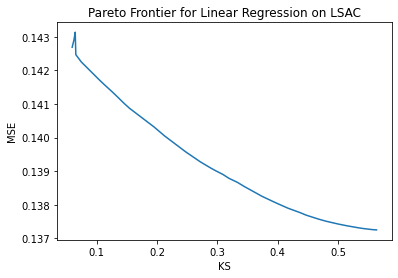

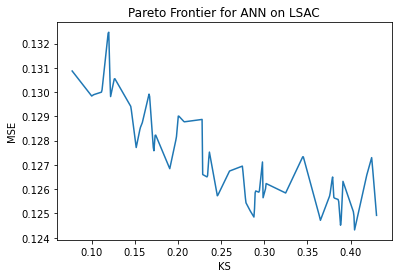

In [36]:
# Pareto frontier (MSE vs KS) plot of linear regression
interploation_model = interp1d(KS_LR, MSE_LR, kind = "linear")

X_LR=np.linspace(KS_LR.min(), KS_LR.max(), 500)
Y_LR=interploation_model(X_LR)
 
plt.plot(X_LR, Y_LR)
plt.title("Pareto Frontier for Linear Regression on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

# Pareto frontier (MSE vs KS) plot of ANN
interploation_model = interp1d(KS_ANN, MSE_ANN, kind = "linear")
 
X_ANN=np.linspace(KS_ANN.min(), KS_ANN.max(), 500)
Y_ANN=interploation_model(X_ANN)
 
plt.plot(X_ANN, Y_ANN)
plt.title("Pareto Frontier for ANN on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()


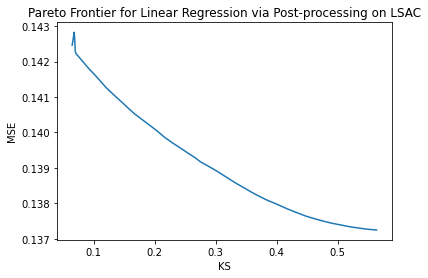

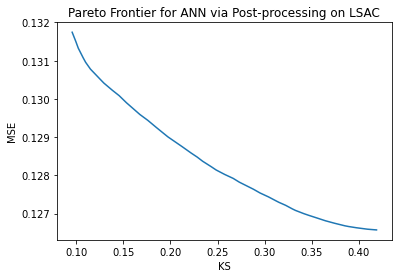

In [37]:
# Pareto frontier (MSE vs KS) plot of linear regression
interploation_model = interp1d(P_KS_LR, P_MSE_LR, kind = "linear")

P_X_LR=np.linspace(P_KS_LR.min(), P_KS_LR.max(), 500)
P_Y_LR=interploation_model(P_X_LR)
 
plt.plot(P_X_LR, P_Y_LR)
plt.title("Pareto Frontier for Linear Regression via Post-processing on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

# Pareto frontier (MSE vs KS) plot of ANN
interploation_model = interp1d(P_KS_ANN, P_MSE_ANN, kind = "linear")
 
P_X_ANN=np.linspace(P_KS_ANN.min(), P_KS_ANN.max(), 500)
P_Y_ANN=interploation_model(P_X_ANN)
 
plt.plot(P_X_ANN, P_Y_ANN)
plt.title("Pareto Frontier for ANN via Post-processing on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

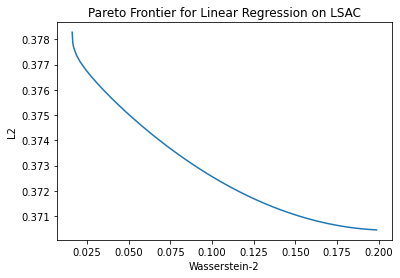

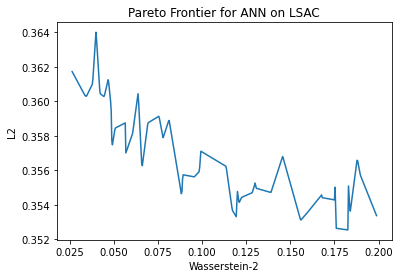

In [38]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(W2_LR, L2_LR, kind = "linear")

X_LR_W2=np.linspace(W2_LR.min(), W2_LR.max(), 500)
Y_LR_W2=interploation_model(X_LR_W2)
 
plt.plot(X_LR_W2, Y_LR_W2)
plt.title("Pareto Frontier for Linear Regression on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(W2_ANN, L2_ANN, kind = "linear")
 
X_ANN_W2=np.linspace(W2_ANN.min(), W2_ANN.max(), 500)
Y_ANN_W2=interploation_model(X_ANN_W2)
 
plt.plot(X_ANN_W2, Y_ANN_W2)
plt.title("Pareto Frontier for ANN on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

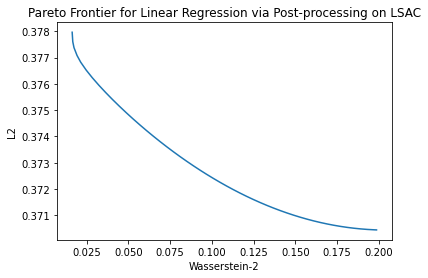

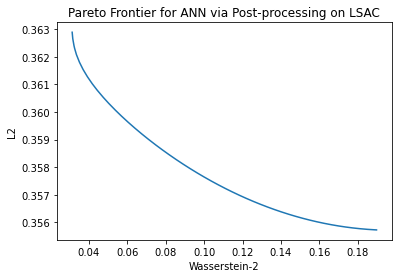

In [39]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(P_W2_LR, P_L2_LR, kind = "linear")

P_X_LR_W2=np.linspace(P_W2_LR.min(), P_W2_LR.max(), 500)
P_Y_LR_W2=interploation_model(P_X_LR_W2)
 
plt.plot(P_X_LR_W2, P_Y_LR_W2)
plt.title("Pareto Frontier for Linear Regression via Post-processing on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(P_W2_ANN, P_L2_ANN, kind = "linear")
 
P_X_ANN_W2=np.linspace(P_W2_ANN.min(), P_W2_ANN.max(), 500)
P_Y_ANN_W2=interploation_model(P_X_ANN_W2)
 
plt.plot(P_X_ANN_W2, P_Y_ANN_W2)
plt.title("Pareto Frontier for ANN via Post-processing on LSAC")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

## MSE and KS of Linear Regression and ANN via the Post-processing Approach in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc..
We implement the post-processing approach ourselves since the authors of "Fair Regression with Wasserstein Barycenters" did not post their code. See the implementation in "Implementation of Fair Regression with Wasserstein Barycenters.py" and the resulting MSE, KS, and time recording are listed below.

In [40]:
# function that finds the barycenter by matching the cumulative distribution functions of two marginal/conditional random variables
def f_NIPS(Y_l, Y_t, Z_l, Z_t):
    u = np.unique(Z_l)
    nM = max([sum(Z_l==u[0]),sum(Z_l==u[1])])
    iM = np.argmax([sum(Z_l==u[0]),sum(Z_l==u[1])])
    nm = min([sum(Z_l==u[0]),sum(Z_l==u[1])])
    im = np.argmin([sum(Z_l==u[0]),sum(Z_l==u[1])])
    p = nm/len(Z_l)
    q = 1-p
    YF = np.zeros(len(Y_t))
    for i in range(0,len(Y_t)):
        print(i)
        if Z_t[i] == u[im]:
            dist_best = math.inf
            for t in np.linspace(min(Y_l),max(Y_l),100):
                tmp1 = sum(Y_l[Z_l==u[iM]] < t)/nM
                tmp2 = sum(Y_l[Z_l==u[im]] < Y_t[i])/nm
                dist = np.abs(tmp1-tmp2)
                if dist_best > dist:
                    dist_best = dist
                    ts = t
            YF[i] = p*Y_t[i]+q*ts
        else:
            dist_best = math.inf
            for t in np.linspace(min(Y_l),max(Y_l),100):
                tmp1 = sum(Y_l[Z_l==u[im]] < t)/nm
                tmp2 = sum(Y_l[Z_l==u[iM]] < Y_t[i])/nM
                dist = np.abs(tmp1-tmp2)
                if dist_best > dist:
                    dist_best = dist
                    ts = t
            YF[i] = q*Y_t[i]+p*ts
    return YF

In [41]:
# train and test sensitive variable and prediction: Z_l(t), Y_l(t)
Z_l = trainZ_list # for CRIME data, use trainZ_list[i] = trainX_list[i][:,96]
Z_t = testZ_list # for CRIME data, use testZ_list[i] = testX_list[i][:,96]
Y_l = Y_hat_list_l # for ANN results, use Y_hat_list_l_ANN instead
Y_t = Y_hat_list_t # for ANN results, use Y_hat_list_t_ANN instead

# compute the predictions on the test sets via the post-processing approach
Y_hat_chzhen_list = []
time_chzhen_list = []

for i in range(len(trainX_list)):
    t = perf_counter()
    Y_hat_chzhen_list.append(f_NIPS(Y_l[i], Y_t[i], Z_l[i], Z_t[i]))
    time_chzhen_list.append(perf_counter() - t)
    
# compute MSE and KS
MSE_chzhen_list = []
KS_chzhen_list = []
W2_chzhen_list = []

for i in range(len(trainX_list)):
    MSE_chzhen_list.append(((testY_list[i] - Y_hat_chzhen_list[i])**2).mean(axis = 0))   # MSE
    KS_result_chzhen = stats.ks_2samp(Y_hat_chzhen_list[i][Z_t[i] == 0], Y_hat_chzhen_list[i][Z_t[i] == 1]) # KS
    KS_chzhen_list.append(KS_result_chzhen[0])
    W2_chzhen_list.append(np.sqrt(ot.emd2_1d(Y_hat_chzhen_list[i][Z_t[i] == 0], Y_hat_chzhen_list[i][Z_t[i] == 1])))
    
L2_chzhen_list = np.sqrt(MSE_chzhen_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
2

1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875


1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690


1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505


1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320


In [42]:
MSE_chzhen_list, KS_chzhen_list, L2_chzhen_list, W2_chzhen_list, time_chzhen_list

([0.14059956098698873,
  0.15205907957654569,
  0.14306635635272527,
  0.137330269234612,
  0.14157344270429173],
 [0.06677001400473871,
  0.07102566977171455,
  0.0809844000648367,
  0.10207056286564303,
  0.09354462955438168],
 array([0.37496608, 0.38994753, 0.37824114, 0.37058099, 0.37626247]),
 [0.017066480327150527,
  0.01945321728354368,
  0.012778361047653017,
  0.018347227681020418,
  0.017019274581430373],
 [6311.358892844997,
  6289.1802818860015,
  6436.233395582996,
  6421.578559900001,
  6444.686643490997])

In [43]:
# compute the predictions on the test sets via the post-processing approach
Y_hat_chzhen_list_ANN = []
time_chzhen_list_ANN = []

for i in range(len(trainX_list)):
    t = perf_counter()
    Y_hat_chzhen_list_ANN.append(f_NIPS(Y_HatPathList_l_ANN[i][0], Y_HatPathList_t_ANN[i][0], Z_l[i], Z_t[i]))
    time_chzhen_list_ANN.append(perf_counter() - t)
    
# compute MSE and KS
MSE_chzhen_list_ANN = []
KS_chzhen_list_ANN = []
W2_chzhen_list_ANN = []

for i in range(len(trainX_list)):
    MSE_chzhen_list_ANN.append(((testY_list[i] - Y_hat_chzhen_list_ANN[i])**2).mean(axis = 0))   # MSE
    KS_result_chzhen = stats.ks_2samp(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1]) # KS
    KS_chzhen_list_ANN.append(KS_result_chzhen[0])
    W2_chzhen_list_ANN.append(np.sqrt(ot.emd2_1d(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1])))
    
L2_chzhen_list_ANN = np.sqrt(MSE_chzhen_list_ANN)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
2

1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875


1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690


1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505


1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320


In [45]:
# compute MSE and KS
MSE_chzhen_list_ANN = []
KS_chzhen_list_ANN = []
W2_chzhen_list_ANN = []

for i in range(len(trainX_list)):
    MSE_chzhen_list_ANN.append(((testY_list[i] - Y_hat_chzhen_list_ANN[i])**2).mean(axis = 0))   # MSE
    KS_result_chzhen = stats.ks_2samp(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1]) # KS
    KS_chzhen_list_ANN.append(KS_result_chzhen[0])
    W2_chzhen_list_ANN.append(np.sqrt(ot.emd2_1d(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1])))

L2_chzhen_list_ANN = np.sqrt(MSE_chzhen_list_ANN)

In [46]:
MSE_chzhen_list_ANN, KS_chzhen_list_ANN, L2_chzhen_list_ANN, W2_chzhen_list_ANN, time_chzhen_list_ANN

([0.13312065782392576,
  0.13928653180126696,
  0.13472215558988287,
  0.1277064072492389,
  0.12393047328117934],
 [0.0646085279169933,
  0.050678598260793906,
  0.06302016086210462,
  0.1117544875506659,
  0.08644182581606392],
 array([0.36485704, 0.37321111, 0.36704517, 0.35736033, 0.3520376 ]),
 [0.021310762984146706,
  0.014028489788521498,
  0.02416921935602683,
  0.02582690417468744,
  0.029863873613100937],
 [2534.444049139005,
  2554.9233392189926,
  3196.9758661570086,
  3044.1462211420003,
  2991.117458818])

### Recording chzhen's results


MSE_chzhen_list = [0.14059956098698873,
  0.15205907957654569,
  0.14306635635272527,
  0.137330269234612,
  0.14157344270429173]
KS_chzhen_list = [0.06677001400473871,
  0.07102566977171455,
  0.0809844000648367,
  0.10207056286564303,
  0.09354462955438168]
L2_chzhen_list = [0.37496608, 0.38994753, 0.37824114, 0.37058099, 0.37626247]
W2_chzhen_list = [0.017066480327150527,
  0.01945321728354368,
  0.012778361047653017,
  0.018347227681020418,
  0.017019274581430373]
time_chzhen_list = [6384.390389710999,
  6429.946280634002,
  12955.774502043998,
  9326.900620519002,
  6854.311249848994]
 

MSE_chzhen_list_ANN = [0.12324532923596815,
  0.14097774040923675,
  0.1325472667872536,
  0.1284290548680901,
  0.12873390883114375]
KS_chzhen_list_ANN =  [0.062163423850334264,
  0.04010180228871089,
  0.06597693825421579,
  0.09036998582353294,
  0.08319653257483407]
L2_chzhen_list_ANN = [0.35106314, 0.37547003, 0.36407041, 0.35837   , 0.35879508]
W2_chzhen_list_ANN = [0.016536902658814148,
  0.012564616303693852,
  0.02039827993911245,
  0.02481761145197665,
  0.018802458926297595]
time_chzhen_list_ANN = [2482.266346471006,
  2436.1035268240084,
  2487.568064838997,
  2481.095251802006,
  2480.6710593710013]
  

## Generate Figures

In [47]:
# mean and standard deviation of the MSE and KS resulting from the comparison methods:

MSE_origin_mean = np.mean(MSE_origin_list)
MSE_d_mean = np.mean(MSE_d_list)
MSE_fair_mean = np.mean(MSE_fair_list)
P_MSE_fair_mean = np.mean(P_MSE_fair_LR)
MSE_chzhen_mean = np.mean(MSE_chzhen_list)

MSE_origin_std = np.std(MSE_origin_list)
MSE_d_std = np.std(MSE_d_list)
MSE_fair_std = np.std(MSE_fair_list)
P_MSE_fair_std = np.std(P_MSE_fair_LR)
MSE_chzhen_std = np.std(MSE_chzhen_list)

L2_origin_mean = np.mean(L2_origin_list)
L2_d_mean = np.mean(L2_d_list)
L2_fair_mean = np.mean(L2_fair_list)
P_L2_fair_mean = np.mean(P_L2_fair_LR)
L2_chzhen_mean = np.mean(L2_chzhen_list)

L2_origin_std = np.std(L2_origin_list)
L2_d_std = np.std(L2_d_list)
L2_fair_std = np.std(L2_fair_list)
P_L2_fair_std = np.std(P_L2_fair_LR)
L2_chzhen_std = np.std(L2_chzhen_list)

KS_origin_mean = np.mean(KS_origin_list)
KS_d_mean = np.mean(KS_d_list)
KS_fair_mean = np.mean(KS_fair_list)
P_KS_fair_mean = np.mean(P_KS_fair_LR) 
KS_chzhen_mean = np.mean(KS_chzhen_list)

KS_origin_std = np.std(KS_origin_list)
KS_d_std = np.std(KS_d_list)
KS_fair_std = np.std(KS_fair_list)
P_KS_fair_std = np.std(P_KS_fair_LR)
KS_chzhen_std = np.std(KS_chzhen_list)

W2_origin_mean = np.mean(W2_origin_list)
W2_d_mean = np.mean(W2_d_list)
W2_fair_mean = np.mean(W2_fair_list)
P_W2_fair_mean = np.mean(P_W2_fair_LR) 
W2_chzhen_mean = np.mean(W2_chzhen_list)

W2_origin_std = np.std(W2_origin_list)
W2_d_std = np.std(W2_d_list)
W2_fair_std = np.std(W2_fair_list)
P_W2_fair_std = np.std(P_W2_fair_LR)
W2_chzhen_std = np.std(W2_chzhen_list)

MSE_origin_mean_ANN = np.mean(MSE_origin_list_ANN)
MSE_d_mean_ANN = np.mean(MSE_d_list_ANN)
MSE_fair_mean_ANN = np.mean(MSE_fair_list_ANN)
P_MSE_fair_mean_ANN = np.mean(P_MSE_fair_ANN)
MSE_chzhen_mean_ANN = np.mean(MSE_chzhen_list_ANN)

MSE_origin_std_ANN = np.std(MSE_origin_list_ANN)
MSE_d_std_ANN = np.std(MSE_d_list_ANN)
MSE_fair_std_ANN = np.std(MSE_fair_list_ANN)
P_MSE_fair_std_ANN = np.std(P_MSE_fair_ANN)
MSE_chzhen_std_ANN = np.std(MSE_chzhen_list_ANN)

L2_origin_mean_ANN = np.mean(L2_origin_list_ANN)
L2_d_mean_ANN = np.mean(L2_d_list_ANN)
L2_fair_mean_ANN = np.mean(L2_fair_list_ANN)
P_L2_fair_mean_ANN = np.mean(P_L2_fair_ANN)
L2_chzhen_mean_ANN = np.mean(L2_chzhen_list_ANN)

L2_origin_std_ANN = np.std(L2_origin_list_ANN)
L2_d_std_ANN = np.std(L2_d_list_ANN)
L2_fair_std_ANN = np.std(L2_fair_list_ANN)
P_L2_fair_std_ANN = np.std(P_L2_fair_ANN)
L2_chzhen_std_ANN = np.std(L2_chzhen_list_ANN)

KS_origin_mean_ANN = np.mean(KS_origin_list_ANN)
KS_d_mean_ANN = np.mean(KS_d_list_ANN)
KS_fair_mean_ANN = np.mean(KS_fair_list_ANN)
P_KS_fair_mean_ANN = np.mean(P_KS_fair_ANN)
KS_chzhen_mean_ANN = np.mean(KS_chzhen_list_ANN)

KS_origin_std_ANN = np.std(KS_origin_list_ANN)
KS_d_std_ANN = np.std(KS_d_list_ANN)
KS_fair_std_ANN = np.std(KS_fair_list_ANN)
P_KS_fair_std_ANN = np.std(P_KS_fair_ANN)
KS_chzhen_std_ANN = np.std(KS_chzhen_list_ANN)

W2_origin_mean_ANN = np.mean(W2_origin_list_ANN)
W2_d_mean_ANN = np.mean(W2_d_list_ANN)
W2_fair_mean_ANN = np.mean(W2_fair_list_ANN)
P_W2_fair_mean_ANN = np.mean(P_W2_fair_ANN) 
W2_chzhen_mean_ANN = np.mean(W2_chzhen_list_ANN)

W2_origin_std_ANN = np.std(W2_origin_list_ANN)
W2_d_std_ANN = np.std(W2_d_list_ANN)
W2_fair_std_ANN = np.std(W2_fair_list_ANN)
P_W2_fair_std_ANN = np.std(P_W2_fair_ANN)
W2_chzhen_std_ANN = np.std(W2_chzhen_list_ANN)

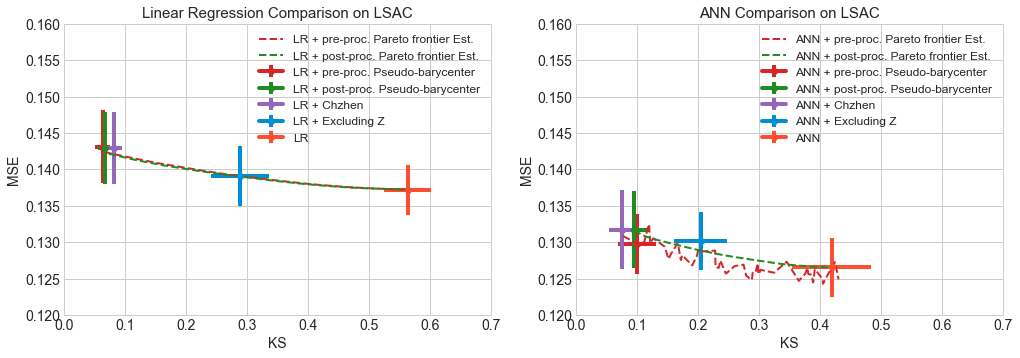

In [61]:
# Generate Figure: L2 vs KS
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight is name of style

axs[0].errorbar(KS_fair_mean, MSE_fair_mean, xerr=KS_fair_std, yerr=MSE_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_KS_fair_mean, P_MSE_fair_mean, xerr=P_KS_fair_std, yerr=P_MSE_fair_std, fmt='-o', color = 'forestgreen') # LR + post-processing pseudo-barycenter
axs[0].errorbar(KS_chzhen_mean, MSE_chzhen_mean, xerr=KS_chzhen_std, yerr=MSE_chzhen_std, fmt='-o',color = '#9467bd') # LR + chzhen
axs[0].errorbar(KS_d_mean, MSE_d_mean, xerr=KS_d_std, yerr=MSE_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(KS_origin_mean, MSE_origin_mean, xerr=KS_origin_std, yerr=MSE_origin_std, fmt='-o') # LR
axs[0].plot(X_LR,Y_LR,linewidth = 2, linestyle='dashed',color = '#d62728') # data representation
axs[0].plot(P_X_LR,P_Y_LR,linewidth = 2,linestyle='dashed', color = 'forestgreen') # post-processing

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + pre-proc. Pareto frontier Est.','LR + post-proc. Pareto frontier Est.','LR + pre-proc. Pseudo-barycenter','LR + post-proc. Pseudo-barycenter','LR + Chzhen','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('MSE', fontsize=14)
axs[0].set_xlabel('KS', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on LSAC", fontsize=15)
axs[0].set_ylim(0.12, 0.16)
axs[0].set_xlim(0, 0.7)

axs[1].errorbar(KS_fair_mean_ANN, MSE_fair_mean_ANN, xerr=KS_fair_std_ANN, yerr=MSE_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_KS_fair_mean_ANN, P_MSE_fair_mean_ANN, xerr=P_KS_fair_std_ANN, yerr=P_MSE_fair_std_ANN, fmt='-o', color = 'forestgreen') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(KS_chzhen_mean_ANN, MSE_chzhen_mean_ANN, xerr=KS_chzhen_std_ANN, yerr=MSE_chzhen_std_ANN, fmt='-o',color = '#9467bd') # ANN + chzhen
axs[1].errorbar(KS_d_mean_ANN, MSE_d_mean_ANN, xerr=KS_d_std_ANN, yerr=MSE_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(KS_origin_mean_ANN, MSE_origin_mean_ANN, xerr=KS_origin_std_ANN, yerr=MSE_origin_std_ANN, fmt='-o') # ANN
axs[1].plot(X_ANN,Y_ANN,linewidth = 2, linestyle='dashed',color = '#d62728') # data representation
axs[1].plot(P_X_ANN,P_Y_ANN,linewidth = 2, linestyle='dashed',color = 'forestgreen') # post-processing

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + pre-proc. Pareto frontier Est.','ANN + post-proc. Pareto frontier Est.','ANN + pre-proc. Pseudo-barycenter','ANN + post-proc. Pseudo-barycenter','ANN + Chzhen','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('MSE', fontsize=14)
axs[1].set_xlabel('KS', fontsize=14)
axs[1].set_title(f"ANN Comparison on LSAC", fontsize=15)
axs[1].set_ylim(0.12, 0.16)
axs[1].set_xlim(0, 0.7)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier LSAC correction version 7', dpi=400,bbox_inches='tight')

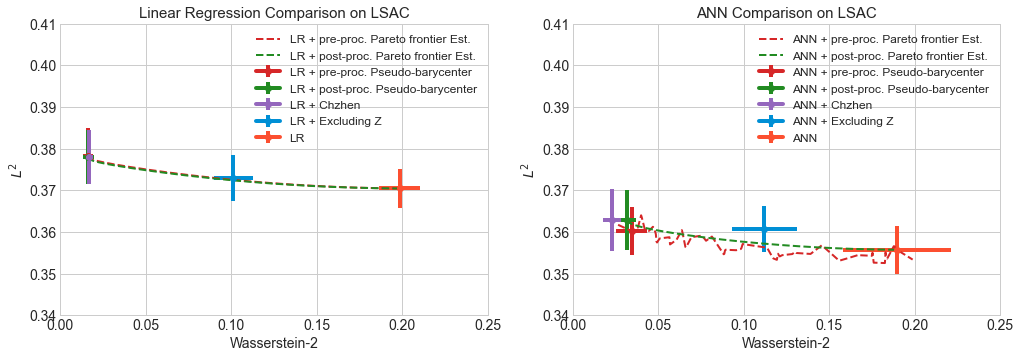

In [60]:
# Generate Figure: L2 vs W2
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight is name of style

axs[0].errorbar(W2_fair_mean, L2_fair_mean, xerr=W2_fair_std, yerr=L2_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_W2_fair_mean, P_L2_fair_mean, xerr=P_W2_fair_std, yerr=P_L2_fair_std, fmt='-o', color = 'forestgreen') # LR + post-processing pseudo-barycenter
axs[0].errorbar(W2_chzhen_mean, L2_chzhen_mean, xerr=W2_chzhen_std, yerr=L2_chzhen_std, fmt='-o',color = '#9467bd') # LR + chzhen
axs[0].errorbar(W2_d_mean, L2_d_mean, xerr=W2_d_std, yerr=L2_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(W2_origin_mean, L2_origin_mean, xerr=W2_origin_std, yerr=L2_origin_std, fmt='-o') # LR
axs[0].plot(X_LR_W2,Y_LR_W2,linewidth = 2, linestyle='dashed', color = '#d62728') # data representation
axs[0].plot(P_X_LR_W2,P_Y_LR_W2,linewidth = 2, linestyle='dashed', color = 'forestgreen') # post-processing

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + pre-proc. Pareto frontier Est.','LR + post-proc. Pareto frontier Est.','LR + pre-proc. Pseudo-barycenter','LR + post-proc. Pseudo-barycenter','LR + Chzhen','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('$L^2$', fontsize=14)
axs[0].set_xlabel('Wasserstein-2', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on LSAC", fontsize=15)
axs[0].set_ylim(0.34, 0.41)
axs[0].set_xlim(0, 0.25)

axs[1].errorbar(W2_fair_mean_ANN, L2_fair_mean_ANN, xerr=W2_fair_std_ANN, yerr=L2_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_W2_fair_mean_ANN, P_L2_fair_mean_ANN, xerr=P_W2_fair_std_ANN, yerr=P_L2_fair_std_ANN, fmt='-o', color = 'forestgreen') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(W2_chzhen_mean_ANN, L2_chzhen_mean_ANN, xerr=W2_chzhen_std_ANN, yerr=L2_chzhen_std_ANN, fmt='-o',color = '#9467bd') # ANN + chzhen
axs[1].errorbar(W2_d_mean_ANN, L2_d_mean_ANN, xerr=W2_d_std_ANN, yerr=L2_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(W2_origin_mean_ANN, L2_origin_mean_ANN, xerr=W2_origin_std_ANN, yerr=L2_origin_std_ANN, fmt='-o') # ANN
axs[1].plot(X_ANN_W2,Y_ANN_W2,linewidth = 2, linestyle='dashed', color = '#d62728') # data representation
axs[1].plot(P_X_ANN_W2,P_Y_ANN_W2,linewidth = 2, linestyle='dashed', color = 'forestgreen') # post-processing

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + pre-proc. Pareto frontier Est.','ANN + post-proc. Pareto frontier Est.','ANN + pre-proc. Pseudo-barycenter','ANN + post-proc. Pseudo-barycenter','ANN + Chzhen','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('$L^2$', fontsize=14)
axs[1].set_xlabel('Wasserstein-2', fontsize=14)
axs[1].set_title(f"ANN Comparison on LSAC", fontsize=15)
axs[1].set_ylim(0.34, 0.41)
axs[1].set_xlim(0, 0.25)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier LSAC L2 vs W2 correction version 7', dpi=400,bbox_inches='tight')